# Final Figures — Cyclone Energetics Paper

This notebook generates all final figures for the paper on cyclone energetics and
the seasonal cycle of poleward energy transport.

**Workflow summary:**
1. Load integrated poleward flux data and cyclone area/intensity fields.
2. Interpolate zonally averaged fields onto a fine latitude grid.
3. Identify storm-track positions from the TE maximum/minimum.
4. Decompose seasonal anomalies into footprint and efficiency terms.
5. Generate bar charts for weak/strong and ocean/land comparisons.
6. Produce 2-D maps and cyclone-centred composites.

In [1]:
%matplotlib inline

import pathlib
import string

import cartopy.crs
import cartopy.feature
import matplotlib as mpl
import matplotlib.colors
import matplotlib.patheffects
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas
import scipy.interpolate
import xarray

A_EARTH = 6.371e6
AREA_CUT = "0.225"
YEAR_START = 1979
YEAR_END = 2015
SEASON_LABELS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                 "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

BASE = pathlib.Path("/project2/tas1/gmsarro")
NC_FLUX = BASE / "cyclone_centered" / f"WITH_INT_Cyclones_Sampled_Poleward_Fluxes_{AREA_CUT}.nc"
NC_ANT_INT = BASE / "track" / "final" / "anticyclonic_intensity.nc"
NC_CYC_INT = BASE / "track" / "final" / "cyclonic_intensity.nc"
CSV_DIR = BASE / "track" / "final"
YEARLY_FILES = [
    BASE / "cyclone_centered" / f"WITH_INT_Cyclones_Sampled_Poleward_Fluxes_YEARS_{s}.nc"
    for s in range(3)
]

INTENSITY_CUT = np.array([1, 2, 3, 4, 5, 6])
HALF_WIN = int(2844 / 2)
PW_FACTOR = 2 * np.pi * A_EARTH / 1e15


def _compute_confidence_numbers():
    """Compute interannual TE variability (CONF_NUM) from yearly data.

    Returns (conf_c_a_SH, conf_c_a_NH, conf_6cvu_SH, conf_6cvu_NH).
    """
    N_YEARS, N_MONTHS = 15, 12
    x_d = np.linspace(0, 719, 719)
    y_d = np.linspace(0, 12, 12)
    x3_d = np.linspace(0, 719, 25600)

    def _load_max_vals(intensity_cut, field_types):
        max_vals = {}
        stage, year_track = 0, 0
        for yr in range(N_YEARS):
            if yr == 5 or yr == 10:
                stage += 1
                year_track -= 5
            with netCDF4.Dataset(str(YEARLY_FILES[stage]), "r") as ds:
                latitude = np.asarray(ds["lat"][:])
                for ft in field_types:
                    vn = f"F_TE_final{ft}" if ft else "F_TE_final"
                    data_zon = np.mean(ds[vn][intensity_cut, :, year_track, :, :], axis=2)
                    spline = scipy.interpolate.RectBivariateSpline(y_d, x_d, data_zon)
                    data_int = spline(y_d, x3_d)
                    for hemi in ("NH", "SH"):
                        if hemi == "NH":
                            st = np.argmax(data_int, axis=1)
                        else:
                            st = np.argmin(data_int, axis=1)
                        max_vals[(hemi, ft, yr)] = np.array([data_int[m, st[m]] for m in range(N_MONTHS)])
            year_track += 1
        return max_vals

    def _smooth3(arr):
        out = np.empty_like(arr)
        out[1:-1] = (arr[:-2] + arr[1:-1] + arr[2:]) / 3.0
        out[0] = (arr[-1] + arr[0] + arr[1]) / 3.0
        out[-1] = (arr[-2] + arr[-1] + arr[0]) / 3.0
        return out

    # All cyclones: cycl + anti
    mv_all = _load_max_vals(0, ["_cycl", "_ant", ""])
    results = {}
    for hemi in ("SH", "NH"):
        conf = np.zeros(N_MONTHS)
        for yr in range(N_YEARS - 1):
            conf += np.abs(
                (mv_all[(hemi, "_cycl", yr + 1)] + mv_all[(hemi, "_ant", yr + 1)])
                - (mv_all[(hemi, "_cycl", yr)] + mv_all[(hemi, "_ant", yr)])
            )
        results[f"c_a_{hemi}"] = np.mean(conf / (N_YEARS - 1))

    # 6+ CVU: cycl only, 3-pt smoothed
    mv_6 = _load_max_vals(5, ["_cycl", ""])
    for hemi in ("SH", "NH"):
        conf = np.zeros(N_MONTHS)
        for yr in range(N_YEARS - 1):
            conf += np.abs(_smooth3(mv_6[(hemi, "_cycl", yr + 1)]) - _smooth3(mv_6[(hemi, "_cycl", yr)]))
        results[f"6cvu_{hemi}"] = np.mean(conf / (N_YEARS - 1))

    return results["c_a_SH"], results["c_a_NH"], results["6cvu_SH"], results["6cvu_NH"]


CONF_NUM_C_A_SH, CONF_NUM_C_A_NH, CONF_NUM_6CVU_SH, CONF_NUM_6CVU_NH = _compute_confidence_numbers()
print(f"CONF_NUM_C_A_SH  = {CONF_NUM_C_A_SH:.16f}")
print(f"CONF_NUM_C_A_NH  = {CONF_NUM_C_A_NH:.16f}")
print(f"CONF_NUM_6CVU_SH = {CONF_NUM_6CVU_SH:.16f}")
print(f"CONF_NUM_6CVU_NH = {CONF_NUM_6CVU_NH:.16f}")

CONF_NUM_C_A_SH  = 0.3035811418802208
CONF_NUM_C_A_NH  = 0.3622525890569070
CONF_NUM_6CVU_SH = 0.1119215122879573
CONF_NUM_6CVU_NH = 0.0708752097838729


In [2]:
def running_mean(*, data, window_size):
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode="same")


def interp_lat_2d(*, field_12x_nlat, x_d, y_d, x3_d, y3_d):
    spline = scipy.interpolate.RectBivariateSpline(y_d, x_d, field_12x_nlat)
    return spline(y3_d, x3_d)


def fine_lat(*, latitude, x_d, x3_d):
    f = scipy.interpolate.interp1d(x_d, latitude)
    return f(x3_d)


def stormtrack_from_total_fte(*, fte_zon_int, lat_fine):
    st_nh = np.argmax(fte_zon_int, axis=1)
    st_sh = np.argmin(fte_zon_int, axis=1)
    return st_nh, st_sh, lat_fine[st_nh], lat_fine[st_sh]


def mean_around_track(*, field_12x_nfine, idx_12, half_win=HALF_WIN):
    out = np.zeros(12)
    for n in range(12):
        i0 = idx_12[n] - half_win
        i1 = idx_12[n] + half_win
        out[n] = np.mean(field_12x_nfine[n, i0:i1])
    return out


def seasonal_diff(x):
    x = np.asarray(x)
    return np.mean(x[[11, 0, 1]]) - np.mean(x[[5, 6, 7]])


def load_nc_var(*, path, variable_name):
    with netCDF4.Dataset(str(path), "r") as ds:
        return ds.variables[variable_name][:]


def allocate_bands_from_variability(*, term2, term3, band_total):
    s2 = np.nanstd(term2)
    s3 = np.nanstd(term3)
    if not np.isfinite(s2 + s3) or (s2 + s3) == 0:
        w2 = 0.5
    else:
        w2 = s2 / (s2 + s3)
    w3 = 1.0 - w2
    return w2 * band_total, w3 * band_total, w2, w3

## Load integrated flux data and compute storm-track positions

In [3]:
with netCDF4.Dataset(str(NC_FLUX)) as ds:
    latitude = ds["lat"][:]
    longitude = ds["lon"][:]

    F_TE_final_total = ds["F_TE_final"][0, :, :, :]
    F_TE_final_cycl_all = ds["F_TE_final_cycl"][0, :, :, :]
    F_TE_final_cycl_strong = ds["F_TE_final_cycl"][5, :, :, :]
    F_TE_final_ant_all = ds["F_TE_final_ant"][0, :, :, :]

    tot_energy_final_cycl_0 = ds["tot_energy_final_cycl"][0, :, :, :]
    tot_energy_final_cycl_5 = ds["tot_energy_final_cycl"][5, :, :, :]
    F_Swabs_final_cycl_0 = ds["F_Swabs_final_cycl"][0, :, :, :]
    F_Swabs_final_cycl_5 = ds["F_Swabs_final_cycl"][5, :, :, :]
    F_Olr_final_cycl_0 = ds["F_Olr_final_cycl"][0, :, :, :]
    F_Olr_final_cycl_5 = ds["F_Olr_final_cycl"][5, :, :, :]
    F_Dhdt_final_cycl_0 = ds["F_Dhdt_final_cycl"][0, :, :, :]
    F_Dhdt_final_cycl_5 = ds["F_Dhdt_final_cycl"][5, :, :, :]
    F_TE_final_cycl_0 = ds["F_TE_final_cycl"][0, :, :, :]
    F_TE_final_cycl_5 = ds["F_TE_final_cycl"][5, :, :, :]
    F_TE_z_final_cycl_0 = ds["F_TE_z_final_cycl"][0, :, :, :]
    F_TE_z_final_cycl_5 = ds["F_TE_z_final_cycl"][5, :, :, :]
    F_u_mse_final_cycl_5 = ds["F_u_mse_final_cycl"][5, :, :, :]

ant_int_final = load_nc_var(path=NC_ANT_INT, variable_name="ant_int_final")
cycl_int_final = load_nc_var(path=NC_CYC_INT, variable_name="cycl_int_final")

nlat = len(latitude)
x_d = np.linspace(0, nlat - 1, nlat)
y_d = np.linspace(0, 12, 12)
x3_d = np.linspace(0, nlat - 1, 25600)
y3_d = np.linspace(0, 12, 12)
Lat = fine_lat(latitude=latitude, x_d=x_d, x3_d=x3_d)

F_TE_final_zon_int = interp_lat_2d(
    field_12x_nlat=np.mean(F_TE_final_total, axis=2),
    x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d,
)
stormtrack_NH, stormtrack_SH, stormtrack_lat_nh, stormtrack_lat_sh = stormtrack_from_total_fte(
    fte_zon_int=F_TE_final_zon_int, lat_fine=Lat,
)
max_TE_position = Lat[np.argmax(F_TE_final_zon_int, axis=1)]
max_TE_SH_position = Lat[np.argmin(F_TE_final_zon_int, axis=1)]

print("Storm-track NH latitudes:", stormtrack_lat_nh)
print("Storm-track SH latitudes:", stormtrack_lat_sh)

Storm-track NH latitudes: [37.88229032 38.75878941 39.29871284 40.90445916 43.3516446  46.64026915
 49.24873042 50.96666862 48.1197996  44.64185124 43.17634478 39.67736044]
Storm-track SH latitudes: [-45.39914645 -46.33174147 -46.37381343 -45.1607387  -43.76535216
 -42.89586507 -43.20439275 -43.73730419 -43.30957264 -43.0571409
 -43.84248408 -45.04854682]


## Load track density CSVs and compute intensity/count seasonality

In [4]:
lat_grid = np.linspace(-90, 90, 181)
cosine_weights = np.cos(np.radians(lat_grid))
lat_res = 181

latitudinally_count_all = np.zeros((12, lat_res), float)
latitudinally_count_6cvu = np.zeros((12, lat_res), float)

for k, month_name in enumerate(SEASON_LABELS):
    grit_count = pandas.read_csv(str(CSV_DIR / f"{month_name}_count.csv")).values
    step = np.nanmean(grit_count, axis=1) * cosine_weights
    latitudinally_count_all[k, :] = step * 3 / (YEAR_END - YEAR_START)

    grit_count_6 = pandas.read_csv(str(CSV_DIR / f"{month_name}_count_6CVU.csv")).values
    step_6 = np.nanmean(grit_count_6, axis=1) * cosine_weights
    latitudinally_count_6cvu[k, :] = step_6 * 3 / (YEAR_END - YEAR_START)

local_count_NH_all = np.zeros(12)
local_count_SH_all = np.zeros(12)
local_count_NH_6cvu = np.zeros(12)
local_count_SH_6cvu = np.zeros(12)

for n in range(12):
    for k in range(lat_res // 2, lat_res):
        if lat_grid[k] == int(Lat[stormtrack_NH[n]]):
            local_count_NH_all[n] = np.mean(
                latitudinally_count_all[n, k - 10 : k + 11]
                - latitudinally_count_6cvu[n, k - 10 : k + 11]
            )
            local_count_NH_6cvu[n] = np.mean(
                latitudinally_count_6cvu[n, k - 10 : k + 11]
            )

for n in range(12):
    for k in range(0, lat_res // 2):
        if lat_grid[k] == int(Lat[stormtrack_SH[n]]):
            local_count_SH_all[n - 6] = np.mean(
                latitudinally_count_all[n, k - 10 : k + 11]
                - latitudinally_count_6cvu[n, k - 10 : k + 11]
            )
            local_count_SH_6cvu[n - 6] = np.mean(
                latitudinally_count_6cvu[n, k - 10 : k + 11]
            )

plot_1_nh = local_count_NH_all - np.mean(local_count_NH_all)
plot_1_sh = local_count_SH_all - np.mean(local_count_SH_all)
plot_1_nh_6cvu = local_count_NH_6cvu - np.mean(local_count_NH_6cvu)
plot_1_sh_6cvu = local_count_SH_6cvu - np.mean(local_count_SH_6cvu)

## Compute area and TE seasonality decomposition (1–5 CVU and 6+ CVU)

In [5]:
def compute_area_means(*, st_nh, st_sh):
    area_mean = {"ant": {"NH": {}, "SH": {}}, "cycl": {"NH": {}, "SH": {}}}
    for cut_idx in range(6):
        ant_zon = np.mean(ant_int_final[cut_idx, :, :, :], axis=2)
        cyc_zon = np.mean(cycl_int_final[cut_idx, :, :, :], axis=2)
        ant_intp = interp_lat_2d(field_12x_nlat=ant_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
        cyc_intp = interp_lat_2d(field_12x_nlat=cyc_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
        bin_num = cut_idx + 1
        area_mean["ant"]["NH"][bin_num] = np.mean(mean_around_track(field_12x_nfine=ant_intp, idx_12=st_nh))
        area_mean["ant"]["SH"][bin_num] = np.mean(mean_around_track(field_12x_nfine=ant_intp, idx_12=st_sh))
        area_mean["cycl"]["NH"][bin_num] = np.mean(mean_around_track(field_12x_nfine=cyc_intp, idx_12=st_nh))
        area_mean["cycl"]["SH"][bin_num] = np.mean(mean_around_track(field_12x_nfine=cyc_intp, idx_12=st_sh))
    return area_mean


area_cycl_all_zon_int = {}
for cut_idx in range(6):
    for prefix, data in [("ant", ant_int_final), ("cycl", cycl_int_final)]:
        zon = np.mean(data[cut_idx, :, :, :], axis=2)
        intp = interp_lat_2d(field_12x_nlat=zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
        nh_vals = mean_around_track(field_12x_nfine=intp, idx_12=stormtrack_NH)
        sh_vals = np.zeros(12)
        for n in range(12):
            sh_vals[n - 6] = np.mean(
                intp[n, stormtrack_SH[n] - HALF_WIN : stormtrack_SH[n] + HALF_WIN]
            )
        area_cycl_all_zon_int[f"{AREA_CUT}max_NH_{cut_idx + 1}_final_{prefix}_zon_int"] = nh_vals
        area_cycl_all_zon_int[f"{AREA_CUT}max_SH_{cut_idx + 1}_final_{prefix}_zon_int"] = sh_vals
        di_nh = nh_vals - np.mean(nh_vals)
        di_sh = sh_vals - np.mean(sh_vals)
        area_cycl_all_zon_int[f"{AREA_CUT}D_I_NH_{cut_idx + 1}_final_{prefix}_zon_int"] = di_nh
        area_cycl_all_zon_int[f"{AREA_CUT}D_I_SH_{cut_idx + 1}_final_{prefix}_zon_int"] = di_sh

area_mean_bins = compute_area_means(st_nh=stormtrack_NH, st_sh=stormtrack_SH)

In [6]:
def load_flux_zonal_exact(*, intensity_idx):
    with netCDF4.Dataset(str(NC_FLUX), "r") as ds:
        lat = ds["lat"][:]
        F_TE_total = ds["F_TE_final"][intensity_idx, :, :, :]
        if intensity_idx == 0:
            base = 5
            sw_cycl = ds["F_Swabs_final_cycl"][0, :, :, :] - ds["F_Swabs_final_cycl"][base, :, :, :]
            olr_cycl = ds["F_Olr_final_cycl"][0, :, :, :] - ds["F_Olr_final_cycl"][base, :, :, :]
            dhdt_cycl = ds["F_Dhdt_final_cycl"][0, :, :, :] - ds["F_Dhdt_final_cycl"][base, :, :, :]
            te_cycl = ds["F_TE_final_cycl"][0, :, :, :] - ds["F_TE_final_cycl"][base, :, :, :]
            tot_cycl = (
                ds["tot_energy_final_cycl"][0, :, :, :]
                - ds["tot_energy_final_cycl"][base, :, :, :]
            ) + dhdt_cycl
            umz_cycl = ds["F_TE_z_final_cycl"][0, :, :, :] - ds["F_TE_z_final_cycl"][base, :, :, :]
        else:
            sw_cycl = ds["F_Swabs_final_cycl"][intensity_idx, :, :, :]
            olr_cycl = ds["F_Olr_final_cycl"][intensity_idx, :, :, :]
            dhdt_cycl = ds["F_Dhdt_final_cycl"][intensity_idx, :, :, :]
            te_cycl = ds["F_TE_final_cycl"][intensity_idx, :, :, :]
            tot_cycl = (
                ds["tot_energy_final_cycl"][intensity_idx, :, :, :]
                + ds["F_Dhdt_final_cycl"][intensity_idx, :, :, :]
            )
            umz_cycl = ds["F_u_mse_final_cycl"][intensity_idx, :, :, :]
    out = {
        "latitude": lat,
        "F_TE_total_zon": np.mean(F_TE_total, axis=2),
        "tot_energy_cycl_zon": np.mean(tot_cycl, axis=2),
        "F_Swabs_cycl_zon": np.mean(sw_cycl, axis=2),
        "F_Olr_cycl_zon": np.mean(olr_cycl, axis=2),
        "F_Dhdt_cycl_zon": np.mean(dhdt_cycl, axis=2),
        "F_TE_cycl_zon": np.mean(te_cycl, axis=2),
        "F_UM_z_cycl_zon": np.mean(umz_cycl, axis=2),
    }
    out["F_Shf_cycl_zon"] = out["tot_energy_cycl_zon"] - out["F_Olr_cycl_zon"] - out["F_Swabs_cycl_zon"]
    return out


def compute_DI_for_intensity(*, intensity_idx, area_mean_bins):
    Z = load_flux_zonal_exact(intensity_idx=intensity_idx)
    lat_f = fine_lat(latitude=Z["latitude"], x_d=x_d, x3_d=x3_d)
    fte_int = interp_lat_2d(
        field_12x_nlat=Z["F_TE_total_zon"], x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d,
    )
    st_nh, st_sh, stlat_nh, stlat_sh = stormtrack_from_total_fte(
        fte_zon_int=fte_int, lat_fine=lat_f,
    )
    bin_num = intensity_idx + 1
    area_nh = area_mean_bins["cycl"]["NH"][bin_num]
    area_sh = area_mean_bins["cycl"]["SH"][bin_num]

    def norm_factor(*, lat_deg, area_mean):
        return A_EARTH * np.cos(np.deg2rad(lat_deg)) * 2 * np.pi * area_mean

    out = {}
    for flux_key, field_name in [
        ("tot_energy", "tot_energy_cycl_zon"),
        ("F_TE", "F_TE_cycl_zon"),
        ("F_Swabs", "F_Swabs_cycl_zon"),
        ("F_Olr", "F_Olr_cycl_zon"),
        ("F_Shf", "F_Shf_cycl_zon"),
        ("F_Dhdt", "F_Dhdt_cycl_zon"),
        ("F_UM_z", "F_UM_z_cycl_zon"),
    ]:
        fld_int = interp_lat_2d(
            field_12x_nlat=Z[field_name], x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d,
        )
        nh_raw = mean_around_track(field_12x_nfine=fld_int, idx_12=st_nh) / norm_factor(
            lat_deg=stlat_nh, area_mean=area_nh,
        )
        sh_raw = mean_around_track(field_12x_nfine=fld_int, idx_12=st_sh) / norm_factor(
            lat_deg=stlat_sh, area_mean=area_sh,
        )
        out[f"D_I_NH_{flux_key}{intensity_idx}"] = nh_raw - np.mean(nh_raw)
        out[f"D_I_SH_{flux_key}{intensity_idx}"] = sh_raw - np.mean(sh_raw)
    out["stormtrack_lat_nh"] = stlat_nh
    out["stormtrack_lat_sh"] = stlat_sh
    return out


DI_weak = compute_DI_for_intensity(intensity_idx=0, area_mean_bins=area_mean_bins)
DI_strong = compute_DI_for_intensity(intensity_idx=5, area_mean_bins=area_mean_bins)

confidence_c_a_SH = CONF_NUM_C_A_SH / 4 / (
    A_EARTH * np.cos(np.deg2rad(np.mean(stormtrack_lat_sh))) * 2 * np.pi
    * (area_mean_bins["cycl"]["SH"][1] + area_mean_bins["ant"]["SH"][1])
)
confidence_c_a_NH = CONF_NUM_C_A_NH / 4 / (
    A_EARTH * np.cos(np.deg2rad(np.mean(stormtrack_lat_nh))) * 2 * np.pi
    * (area_mean_bins["cycl"]["NH"][1] + area_mean_bins["ant"]["NH"][1])
)
confidence_6cvu_SH = CONF_NUM_6CVU_SH / 2 / (
    A_EARTH * np.cos(np.deg2rad(np.mean(stormtrack_lat_nh))) * 2 * np.pi
    * area_mean_bins["cycl"]["NH"][5]
)
confidence_6cvu_NH = CONF_NUM_6CVU_NH / 2 / (
    A_EARTH * np.cos(np.deg2rad(np.mean(stormtrack_lat_sh))) * 2 * np.pi
    * area_mean_bins["cycl"]["SH"][5]
)

confidence_6cvu_SH_track = 0.6610716237042479 / 2.5
confidence_6cvu_NH_track = 0.36348897259838214 / 2.5

## Compute TE seasonality decomposition terms (footprint vs efficiency)

In [7]:
def _compute_3term_decomposition(*, intensity_idx, area_cut_str, di_dict):
    with netCDF4.Dataset(str(NC_FLUX)) as ds:
        lat = ds["lat"][:]
        F_TE_total = ds["F_TE_final"][intensity_idx, :, :, :]
        if intensity_idx == 0:
            F_TE_cycl = ds["F_TE_final_cycl"][0, :, :, :] - ds["F_TE_final_cycl"][5, :, :, :]
        else:
            F_TE_cycl = ds["F_TE_final_cycl"][intensity_idx, :, :, :]

    F_TE_total_zon = np.mean(F_TE_total, axis=2)
    F_TE_cycl_zon = np.mean(F_TE_cycl, axis=2)
    F_TE_total_int = interp_lat_2d(field_12x_nlat=F_TE_total_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
    F_TE_cycl_int = interp_lat_2d(field_12x_nlat=F_TE_cycl_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)

    lat_f = fine_lat(latitude=lat, x_d=x_d, x3_d=x3_d)
    st_nh_t, st_sh_t, _, _ = stormtrack_from_total_fte(fte_zon_int=F_TE_total_int, lat_fine=lat_f)

    cut = 0 if intensity_idx == 0 else 5
    area_key_nh = f"{area_cut_str}max_NH_{INTENSITY_CUT[cut]}_final_cycl_zon_int"
    area_key_sh = f"{area_cut_str}max_SH_{INTENSITY_CUT[cut]}_final_cycl_zon_int"
    area_nh = area_cycl_all_zon_int[area_key_nh]
    area_sh = area_cycl_all_zon_int[area_key_sh]

    first_term_NH = np.zeros(12)
    first_term_SH = np.zeros(12)
    for n in range(12):
        flux_nh = np.mean(F_TE_cycl_int[n, st_nh_t[n] - HALF_WIN : st_nh_t[n] + HALF_WIN])
        flux_sh = np.mean(F_TE_cycl_int[n, st_sh_t[n] - HALF_WIN : st_sh_t[n] + HALF_WIN])
        first_term_NH[n] = flux_nh / (
            np.cos(np.deg2rad(lat_f[st_nh_t[n]])) * area_nh[n]
        )
        first_term_SH[n] = flux_sh / (
            np.cos(np.deg2rad(lat_f[st_sh_t[n]])) * area_sh[n - 6]
        )

    plot_2_nh = np.zeros(12)
    plot_2_sh = np.zeros(12)
    plot_4_nh = np.zeros(12)
    plot_4_sh = np.zeros(12)
    plot_5_nh = np.zeros(12)
    plot_5_sh = np.zeros(12)

    for n in range(12):
        flux_nh = np.mean(F_TE_cycl_int[n, st_nh_t[n] - HALF_WIN : st_nh_t[n] + HALF_WIN])
        flux_sh = np.mean(F_TE_cycl_int[n, st_sh_t[n] - HALF_WIN : st_sh_t[n] + HALF_WIN])

        plot_2_nh[n] = flux_nh / (
            np.cos(np.deg2rad(lat_f[st_nh_t[n]])) * np.mean(area_nh)
        )
        plot_2_sh[n] = flux_sh / (
            np.cos(np.deg2rad(lat_f[st_sh_t[n]])) * np.mean(area_sh)
        )
        plot_4_nh[n] = flux_nh / (
            np.cos(np.deg2rad(lat_f[st_nh_t[n]])) * area_nh[n]
        )
        plot_4_sh[n] = flux_sh / (
            np.cos(np.deg2rad(lat_f[st_sh_t[n]])) * area_sh[n - 6]
        )
        plot_5_nh[n] = np.mean(first_term_NH) * (
            np.cos(np.deg2rad(lat_f[st_nh_t[n]])) * area_nh[n]
        ) / np.mean(area_nh)
        plot_5_sh[n] = np.mean(first_term_SH) * (
            np.cos(np.deg2rad(lat_f[st_sh_t[n]])) * area_sh[n - 6]
        ) / np.mean(area_sh)

    return {
        "plot_2_nh": plot_2_nh - np.mean(plot_2_nh),
        "plot_2_sh": plot_2_sh - np.mean(plot_2_sh),
        "plot_4_nh": plot_4_nh - np.mean(plot_4_nh),
        "plot_4_sh": plot_4_sh - np.mean(plot_4_sh),
        "plot_5_nh": plot_5_nh - np.mean(plot_5_nh),
        "plot_5_sh": plot_5_sh - np.mean(plot_5_sh),
        "first_term_NH": first_term_NH,
        "first_term_SH": first_term_SH,
    }


decomp_15 = _compute_3term_decomposition(
    intensity_idx=0, area_cut_str=AREA_CUT, di_dict=DI_weak,
)
decomp_6 = _compute_3term_decomposition(
    intensity_idx=5, area_cut_str=AREA_CUT, di_dict=DI_strong,
)

## Figure 1 — Seasonality 3-panel (total transport, footprint, efficiency)

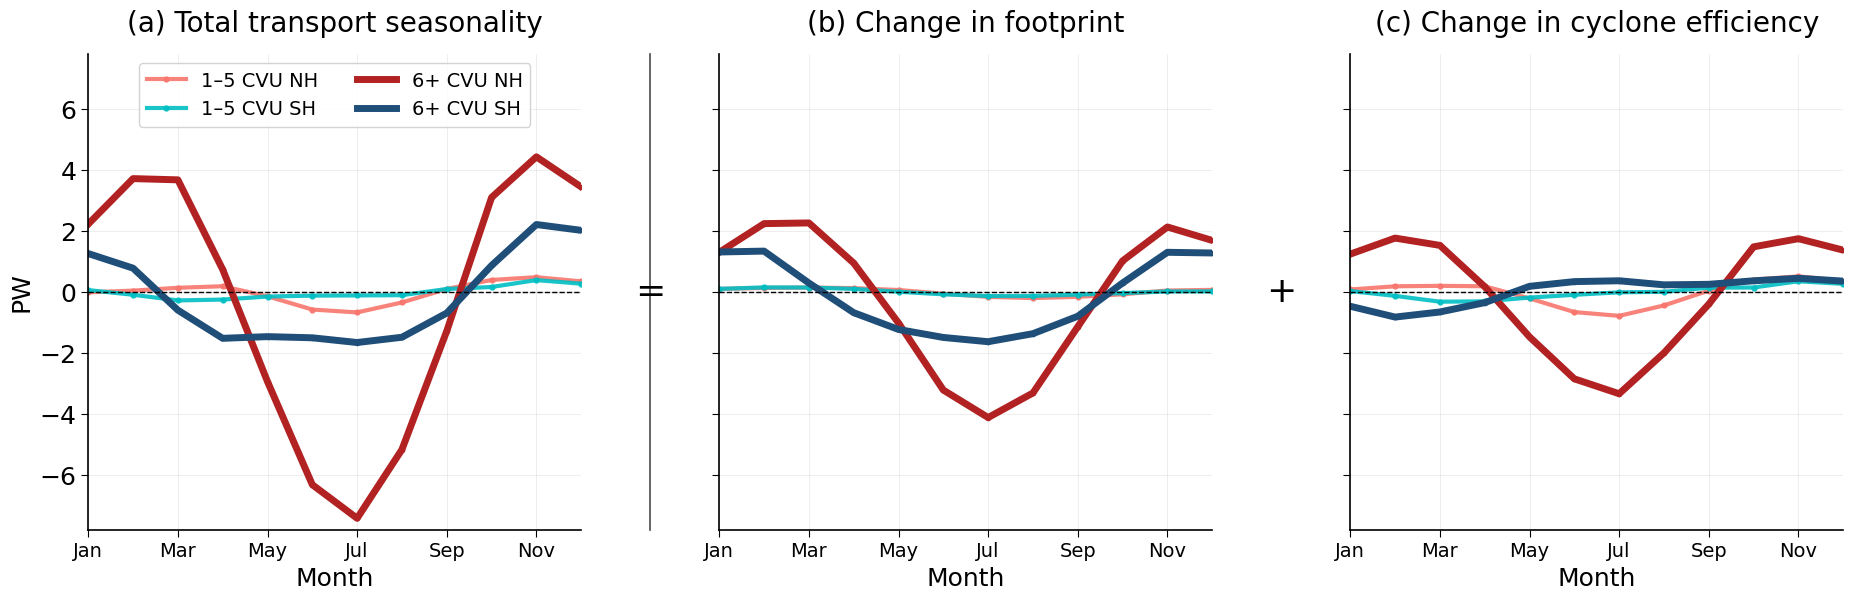

In [8]:
mpl.rcParams.update({
    "font.size": 18,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.2,
    "xtick.major.size": 5,
    "ytick.major.size": 5,
})

RED_LIGHT = "#f8766d"
RED_DARK = "#b22222"
BLUE_LIGHT = "#00bfc4"
BLUE_DARK = "#1f4e79"
GRAY_BAND = "0.85"

SMOOTH_WINDOW = 3
x_ax = np.arange(12)
xlabels = SEASON_LABELS

t1_nh_15 = running_mean(data=decomp_15["plot_2_nh"], window_size=SMOOTH_WINDOW)
t1_sh_15 = running_mean(data=decomp_15["plot_2_sh"], window_size=SMOOTH_WINDOW)
t1_nh_6 = running_mean(data=decomp_6["plot_2_nh"], window_size=SMOOTH_WINDOW)
t1_sh_6 = running_mean(data=decomp_6["plot_2_sh"], window_size=SMOOTH_WINDOW)

t2_nh_15 = running_mean(data=decomp_15["plot_5_nh"], window_size=SMOOTH_WINDOW)
t2_sh_15 = running_mean(data=decomp_15["plot_5_sh"], window_size=SMOOTH_WINDOW)
t2_nh_6 = running_mean(data=decomp_6["plot_5_nh"], window_size=SMOOTH_WINDOW)
t2_sh_6 = running_mean(data=decomp_6["plot_5_sh"], window_size=SMOOTH_WINDOW)

t3_nh_15 = running_mean(data=decomp_15["plot_4_nh"], window_size=SMOOTH_WINDOW)
t3_sh_15 = running_mean(data=decomp_15["plot_4_sh"], window_size=SMOOTH_WINDOW)
t3_nh_6 = running_mean(data=decomp_6["plot_4_nh"], window_size=SMOOTH_WINDOW)
t3_sh_6 = running_mean(data=decomp_6["plot_4_sh"], window_size=SMOOTH_WINDOW)

band_t1 = float(np.nanmax([np.abs(confidence_6cvu_NH), np.abs(confidence_6cvu_SH)]))
band_t2, band_t3, w2, w3 = allocate_bands_from_variability(
    term2=t2_sh_6, term3=t3_sh_6, band_total=band_t1,
)

all_series = np.array([
    t1_nh_15, t1_sh_15, t1_nh_6, t1_sh_6,
    t2_nh_15, t2_sh_15, t2_nh_6, t2_sh_6,
    t3_nh_15, t3_sh_15, t3_nh_6, t3_sh_6,
], dtype=float)
ymax = 1.05 * np.nanmax([np.nanmax(np.abs(all_series)), band_t1, band_t2, band_t3])
ylims = (-ymax, ymax)

fig, axs = plt.subplots(1, 3, figsize=(19.5, 6.8), sharey=True, constrained_layout=False)
fig.subplots_adjust(left=0.085, right=0.985, top=0.90, bottom=0.20, wspace=0.28)

MS_15, LW_15, LW_6, ALPHA_15 = 7, 3, 5, 0.9

for j, ax in enumerate(axs):
    ax.set_xlim(x_ax[0], x_ax[-1])
    ax.grid(True, linewidth=0.6, alpha=0.25)
    ax.set_xticks(x_ax[::2])
    ax.set_xticklabels([xlabels[i] for i in range(0, 12, 2)], fontsize=14)
    ax.set_ylim(*ylims)
    if j > 0:
        ax.tick_params(labelleft=False)

ax0 = axs[0]
ax0.axhspan(-band_t1, band_t1, color=GRAY_BAND, alpha=0.6, zorder=0)
l1, = ax0.plot(x_ax, t1_nh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=RED_LIGHT, label="1\u20135 CVU NH")
l2, = ax0.plot(x_ax, t1_sh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=BLUE_LIGHT, label="1\u20135 CVU SH")
l3, = ax0.plot(x_ax, t1_nh_6, marker=".", lw=LW_6, color=RED_DARK, label="6+ CVU NH")
l4, = ax0.plot(x_ax, t1_sh_6, marker=".", lw=LW_6, color=BLUE_DARK, label="6+ CVU SH")
ax0.axhline(0, color="black", ls="--", lw=1)
ax0.set_title("(a) Total transport seasonality", fontsize=20, pad=16)
ax0.set_xlabel("Month", fontsize=18)
ax0.set_ylabel("PW", fontsize=18)
ax0.legend([l1, l2, l3, l4], [h.get_label() for h in [l1, l2, l3, l4]],
           fontsize=14, frameon=True, framealpha=0.85, loc="upper center",
           bbox_to_anchor=(0.5, 1), ncol=2)

ax1 = axs[1]
ax1.axhspan(-band_t2, band_t2, color=GRAY_BAND, alpha=0.6, zorder=0)
ax1.plot(x_ax, t2_nh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=RED_LIGHT)
ax1.plot(x_ax, t2_sh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=BLUE_LIGHT)
ax1.plot(x_ax, t2_nh_6, marker=".", lw=LW_6, color=RED_DARK)
ax1.plot(x_ax, t2_sh_6, marker=".", lw=LW_6, color=BLUE_DARK)
ax1.axhline(0, color="black", ls="--", lw=1)
ax1.set_title("(b) Change in footprint", fontsize=20, pad=16)
ax1.set_xlabel("Month", fontsize=18)

ax2 = axs[2]
ax2.axhspan(-band_t3, band_t3, color=GRAY_BAND, alpha=0.6, zorder=0)
ax2.plot(x_ax, t3_nh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=RED_LIGHT)
ax2.plot(x_ax, t3_sh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=BLUE_LIGHT)
ax2.plot(x_ax, t3_nh_6, marker=".", lw=LW_6, color=RED_DARK)
ax2.plot(x_ax, t3_sh_6, marker=".", lw=LW_6, color=BLUE_DARK)
ax2.axhline(0, color="black", ls="--", lw=1)
ax2.set_title("(c) Change in cyclone efficiency", fontsize=20, pad=16)
ax2.set_xlabel("Month", fontsize=18)

pos0 = ax0.get_position()
pos1 = ax1.get_position()
pos2 = ax2.get_position()
x_sep = 0.5 * (pos0.x1 + pos1.x0)
y0_fig = min(pos0.y0, pos1.y0, pos2.y0)
y1_fig = max(pos0.y1, pos1.y1, pos2.y1)
fig.add_artist(mpl.lines.Line2D([x_sep, x_sep], [y0_fig, y1_fig],
               transform=fig.transFigure, color="black", lw=1.2, alpha=0.7))
fig.text(x_sep, 0.5 * (y0_fig + y1_fig), "=", ha="center", va="center", fontsize=26)
x_plus = 0.5 * (pos1.x1 + pos2.x0)
fig.text(x_plus, 0.5 * (y0_fig + y1_fig), "+", ha="center", va="center", fontsize=26)

plt.savefig("Seasonality_3panel_PW.png", dpi=600, facecolor="white", bbox_inches="tight")
plt.savefig("Seasonality_3panel_PW.pdf", dpi=600, facecolor="white", bbox_inches="tight")
plt.show()

## Figure 2 — Area percent and track density seasonality

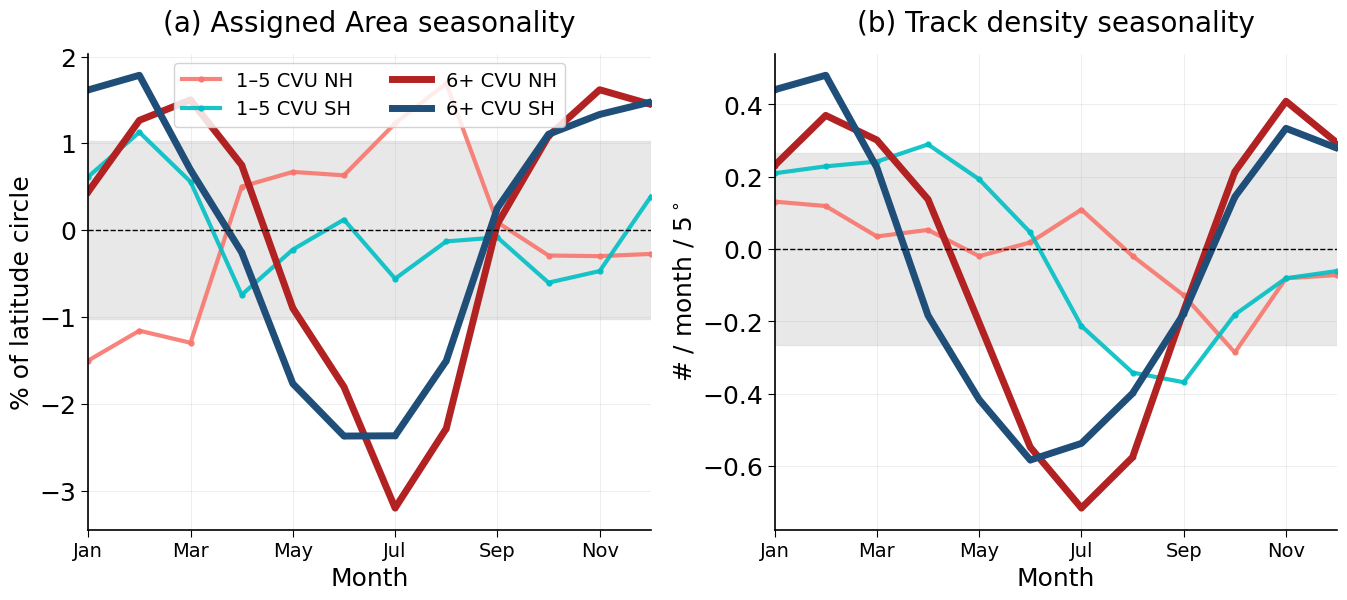

In [9]:
area_nh_15 = area_cycl_all_zon_int[f"{AREA_CUT}max_NH_1_final_cycl_zon_int"]
area_sh_15 = area_cycl_all_zon_int[f"{AREA_CUT}max_SH_1_final_cycl_zon_int"]
area_nh_6 = area_cycl_all_zon_int[f"{AREA_CUT}max_NH_6_final_cycl_zon_int"]
area_sh_6 = area_cycl_all_zon_int[f"{AREA_CUT}max_SH_6_final_cycl_zon_int"]

AREA_TO_PERCENT = 100.0
area_nh_15_anom = AREA_TO_PERCENT * area_nh_15 - np.nanmean(AREA_TO_PERCENT * area_nh_15)
area_sh_15_anom = AREA_TO_PERCENT * area_sh_15 - np.nanmean(AREA_TO_PERCENT * area_sh_15)
area_nh_6_anom = AREA_TO_PERCENT * area_nh_6 - np.nanmean(AREA_TO_PERCENT * area_nh_6)
area_sh_6_anom = AREA_TO_PERCENT * area_sh_6 - np.nanmean(AREA_TO_PERCENT * area_sh_6)

band_track = float(np.nanmax([np.abs(confidence_6cvu_SH_track), np.abs(confidence_6cvu_NH_track)]))

td_nh_15 = running_mean(data=plot_1_nh, window_size=3)
td_sh_15 = running_mean(data=plot_1_sh, window_size=3)
td_nh_6 = running_mean(data=plot_1_nh_6cvu, window_size=3)
td_sh_6 = running_mean(data=plot_1_sh_6cvu, window_size=3)

fig, axs = plt.subplots(1, 2, figsize=(13.8, 6.8), constrained_layout=False)
fig.subplots_adjust(left=0.08, right=0.985, top=0.90, bottom=0.20, wspace=0.22)

for ax in axs:
    ax.set_xlim(x_ax[0], x_ax[-1])
    ax.grid(True, linewidth=0.6, alpha=0.25)
    ax.set_xticks(x_ax[::2])
    ax.set_xticklabels([xlabels[i] for i in range(0, 12, 2)], fontsize=14)

ax0 = axs[0]
band_area = 1.027
ax0.axhspan(-band_area, band_area, color=GRAY_BAND, alpha=0.6, zorder=0)
l1, = ax0.plot(x_ax, area_nh_15_anom, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=RED_LIGHT, label="1\u20135 CVU NH")
l2, = ax0.plot(x_ax, area_sh_15_anom, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=BLUE_LIGHT, label="1\u20135 CVU SH")
l3, = ax0.plot(x_ax, area_nh_6_anom, marker=".", lw=LW_6, color=RED_DARK, label="6+ CVU NH")
l4, = ax0.plot(x_ax, area_sh_6_anom, marker=".", lw=LW_6, color=BLUE_DARK, label="6+ CVU SH")
ax0.axhline(0, color="black", ls="--", lw=1)
ax0.set_title("(a) Assigned Area seasonality", fontsize=20, pad=16)
ax0.set_xlabel("Month", fontsize=18)
ax0.set_ylabel("% of latitude circle", fontsize=18)
ax0.legend([l1, l2, l3, l4], [h.get_label() for h in [l1, l2, l3, l4]],
           fontsize=14, frameon=True, framealpha=0.85, loc="upper center",
           bbox_to_anchor=(0.5, 1), ncol=2)

ax1 = axs[1]
ax1.axhspan(-band_track, band_track, color=GRAY_BAND, alpha=0.6, zorder=0)
ax1.plot(x_ax, td_nh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=RED_LIGHT)
ax1.plot(x_ax, td_sh_15, "-", marker=".", ms=MS_15, lw=LW_15, alpha=ALPHA_15, color=BLUE_LIGHT)
ax1.plot(x_ax, td_nh_6, marker=".", lw=LW_6, color=RED_DARK)
ax1.plot(x_ax, td_sh_6, marker=".", lw=LW_6, color=BLUE_DARK)
ax1.axhline(0, color="black", ls="--", lw=1)
ax1.set_title("(b) Track density seasonality", fontsize=20, pad=16)
ax1.set_xlabel("Month", fontsize=18)
ax1.set_ylabel(r"# / month / 5$^\circ$", fontsize=18)

plt.savefig("AreaPercent_and_TrackDensity_Seasonality.png", dpi=600, facecolor="white", bbox_inches="tight")
plt.savefig("AreaPercent_and_TrackDensity_Seasonality.pdf", dpi=600, facecolor="white", bbox_inches="tight")
plt.show()

## Figure 3 — Time and zonal mean transient-eddy transport

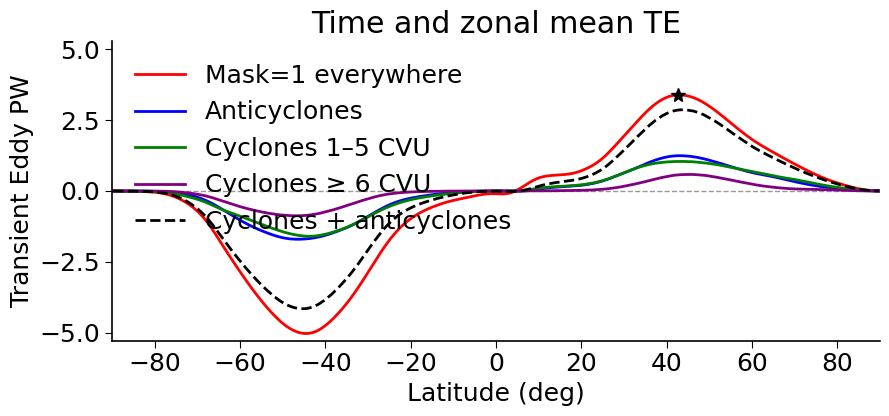

In [10]:
F_TE_cycl_weak = F_TE_final_cycl_all - F_TE_final_cycl_strong
F_TE_cycl_plus_ant = F_TE_final_cycl_all + F_TE_final_ant_all

def zonal_time_mean(field):
    return field.mean(axis=(0, 2))

TE_total_lat = zonal_time_mean(F_TE_final_total)
TE_ant_lat = zonal_time_mean(F_TE_final_ant_all)
TE_cycl_weak_lat = zonal_time_mean(F_TE_cycl_weak)
TE_cycl_strong_lat = zonal_time_mean(F_TE_final_cycl_strong)
TE_cycl_plus_ant_lat = zonal_time_mean(F_TE_cycl_plus_ant)

window = 15
TE_total_smooth = running_mean(data=TE_total_lat, window_size=window)
TE_ant_smooth = running_mean(data=TE_ant_lat, window_size=window)
TE_cycl_weak_smooth = running_mean(data=TE_cycl_weak_lat, window_size=window)
TE_cycl_strong_smooth = running_mean(data=TE_cycl_strong_lat, window_size=window)
TE_cycl_plus_ant_smooth = running_mean(data=TE_cycl_plus_ant_lat, window_size=window)

if not np.all(np.diff(latitude) > 0):
    sort_idx = np.argsort(latitude)
    lat_sorted = latitude[sort_idx]
    TE_total_smooth = TE_total_smooth[sort_idx]
    TE_ant_smooth = TE_ant_smooth[sort_idx]
    TE_cycl_weak_smooth = TE_cycl_weak_smooth[sort_idx]
    TE_cycl_strong_smooth = TE_cycl_strong_smooth[sort_idx]
    TE_cycl_plus_ant_smooth = TE_cycl_plus_ant_smooth[sort_idx]
else:
    lat_sorted = latitude

nh_mask = (lat_sorted >= 10) & (lat_sorted <= 80)
if nh_mask.any():
    nh_idx = np.argmax(TE_total_smooth[nh_mask])
    storm_idx = np.where(nh_mask)[0][nh_idx]
    storm_lat = lat_sorted[storm_idx]
    storm_val = TE_total_smooth[storm_idx]

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.axhline(0, color="0.6", linestyle="--", linewidth=1)
ax.plot(lat_sorted, TE_total_smooth, color="red", linewidth=2.0, label="Mask=1 everywhere")
ax.plot(lat_sorted, TE_ant_smooth, color="blue", linewidth=2.0, label="Anticyclones")
ax.plot(lat_sorted, TE_cycl_weak_smooth, color="green", linewidth=2.0, label="Cyclones 1\u20135 CVU")
ax.plot(lat_sorted, TE_cycl_strong_smooth, color="purple", linewidth=2.0, label="Cyclones \u2265 6 CVU")
ax.plot(lat_sorted, TE_cycl_plus_ant_smooth, linestyle="--", linewidth=2.0, color="black",
        label="Cyclones + anticyclones")
if nh_mask.any():
    ax.plot(storm_lat, storm_val, marker="*", markersize=10, color="k", zorder=5)
ax.set_xlim(-90, 90)
ymax = np.max(np.abs([TE_total_smooth, TE_ant_smooth, TE_cycl_weak_smooth,
                       TE_cycl_strong_smooth, TE_cycl_plus_ant_smooth]))
ax.set_ylim(-1.05 * ymax, 1.05 * ymax)
ax.set_xlabel("Latitude (deg)")
ax.set_ylabel("Transient Eddy PW")
ax.set_title("Time and zonal mean TE")
ax.legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

## Figure 4 — Weak vs strong cyclones bar chart (PW)

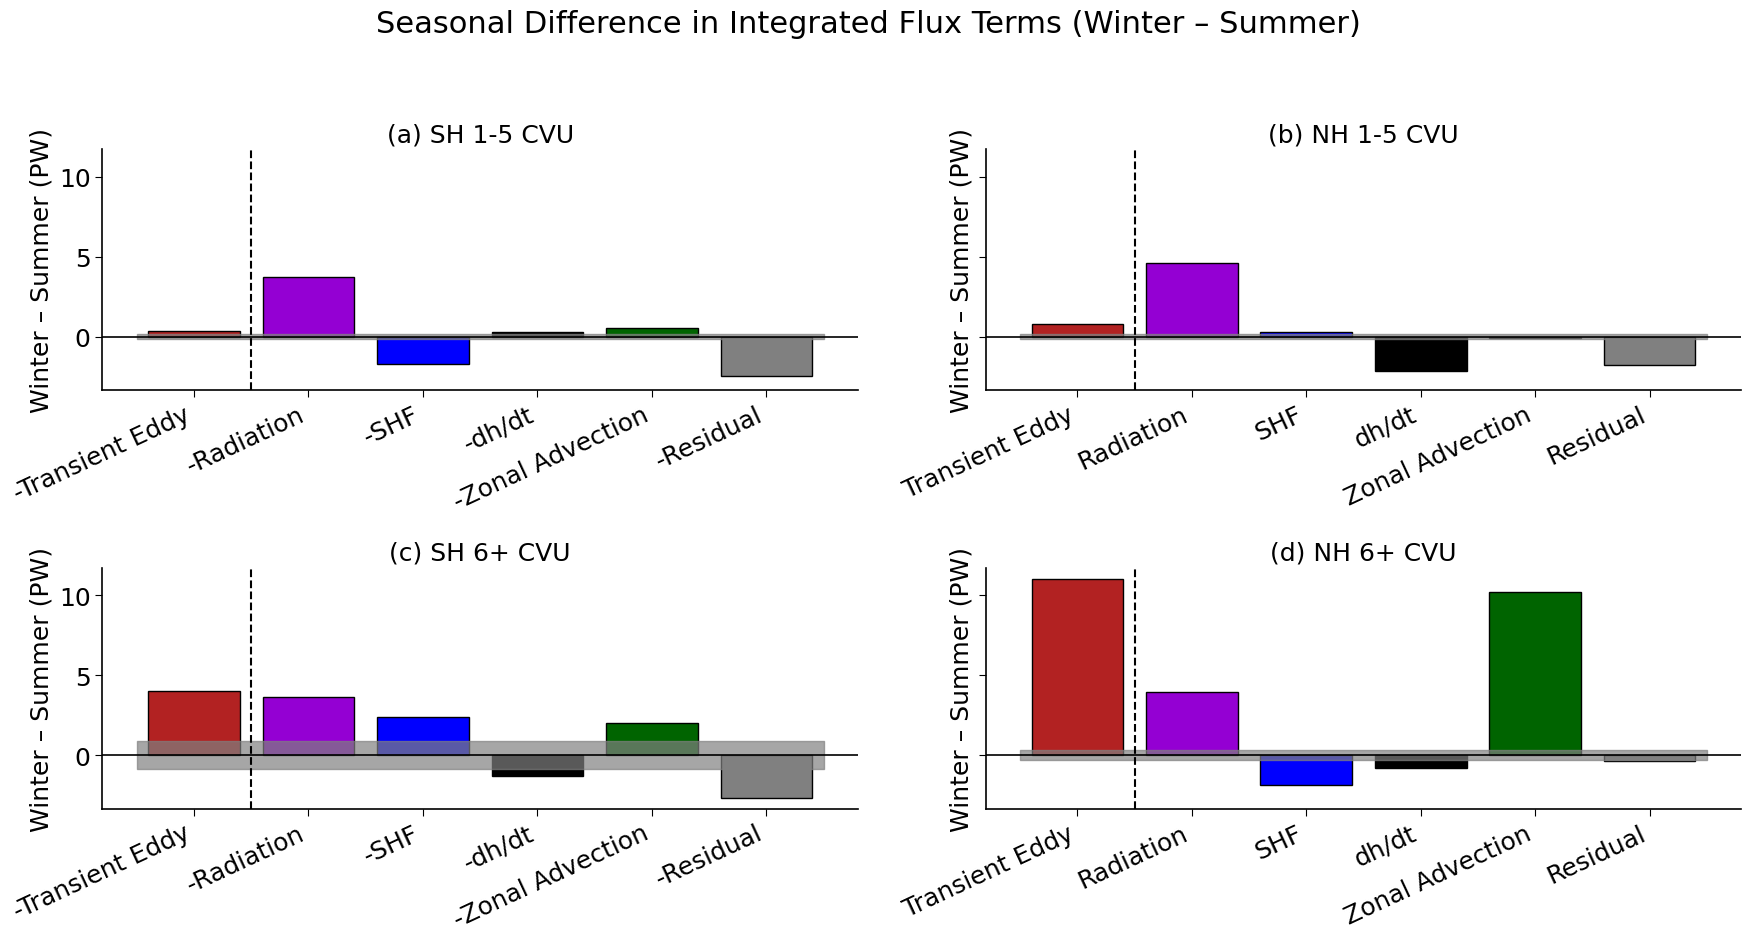

In [11]:
flux_labels_base = ["Transient Eddy", "Radiation", "SHF", "dh/dt", "Zonal Advection", "Residual"]
bar_colors = ["firebrick", "darkviolet", "blue", "black", "darkgreen", "gray"]

panels = [
    ("SH", 0, confidence_c_a_SH, "SH 1-5 CVU"),
    ("NH", 0, confidence_c_a_NH, "NH 1-5 CVU"),
    ("SH", 5, confidence_6cvu_SH, "SH 6+ CVU"),
    ("NH", 5, confidence_6cvu_NH, "NH 6+ CVU"),
]

data_dict = {}
for key, val in DI_weak.items():
    if not key.startswith("stormtrack"):
        data_dict[key] = val
for key, val in DI_strong.items():
    if not key.startswith("stormtrack"):
        data_dict[key] = val

fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharey=True)

for i, (ax, (hemi, icut, conf, title)) in enumerate(zip(axs.flat, panels)):
    values = []
    te = data_dict[f"D_I_{hemi}_F_TE{icut}"] * 1e15 * PW_FACTOR
    values.append(np.mean(te[[11, 0, 1]]) - np.mean(te[[5, 6, 7]]))

    swabs = data_dict[f"D_I_{hemi}_F_Swabs{icut}"] * 1e15 * PW_FACTOR
    olr = data_dict[f"D_I_{hemi}_F_Olr{icut}"] * 1e15 * PW_FACTOR
    values.append(np.mean((swabs + olr)[[11, 0, 1]]) - np.mean((swabs + olr)[[5, 6, 7]]))

    shf = data_dict[f"D_I_{hemi}_F_Shf{icut}"] * 1e15 * PW_FACTOR
    values.append(np.mean(shf[[11, 0, 1]]) - np.mean(shf[[5, 6, 7]]))

    dhdt = -data_dict[f"D_I_{hemi}_F_Dhdt{icut}"] * 1e15 * PW_FACTOR
    values.append(np.mean(dhdt[[11, 0, 1]]) - np.mean(dhdt[[5, 6, 7]]))

    umz = -data_dict[f"D_I_{hemi}_F_UM_z{icut}"] * 1e15 * PW_FACTOR
    values.append(np.mean(umz[[11, 0, 1]]) - np.mean(umz[[5, 6, 7]]))

    tot = data_dict[f"D_I_{hemi}_tot_energy{icut}"] * 1e15 * PW_FACTOR
    te_raw = data_dict[f"D_I_{hemi}_F_TE{icut}"]
    dhdt_raw = data_dict[f"D_I_{hemi}_F_Dhdt{icut}"]
    tot_raw = data_dict[f"D_I_{hemi}_tot_energy{icut}"]
    umz_raw = data_dict[f"D_I_{hemi}_F_UM_z{icut}"]
    residual = (te_raw - (tot_raw - dhdt_raw) + umz_raw) * 1e15 * PW_FACTOR
    values.append(np.mean(residual[[11, 0, 1]]) - np.mean(residual[[5, 6, 7]]))

    x_bar = np.arange(len(values))
    ax.bar(x_bar, values, color=bar_colors, edgecolor="black")
    ax.axvline(0.5, color="black", linestyle="--", linewidth=1.5)
    ax.fill_between([-0.5, len(x_bar) - 0.5],
                    conf * 1e15 * PW_FACTOR, -conf * 1e15 * PW_FACTOR,
                    color="gray", alpha=0.7)
    ax.axhline(0, color="black", linestyle="-", linewidth=1.2)

    if hemi == "SH":
        flux_labels = [f"-{lab}" for lab in flux_labels_base]
    else:
        flux_labels = flux_labels_base
    ax.set_xticks(x_bar)
    ax.set_xticklabels(flux_labels, rotation=25, fontsize=18, ha="right")
    letter = string.ascii_lowercase[i]
    ax.set_title(f"({letter}) {title}", fontsize=18)
    ax.set_ylabel("Winter \u2013 Summer (PW)", fontsize=18)
    ax.tick_params(axis="y", labelsize=18)

fig.suptitle("Seasonal Difference in Integrated Flux Terms (Winter \u2013 Summer)", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("weak_vs_strong_PW_winter_minus_summer_textonly.png", dpi=300, bbox_inches="tight")
plt.show()

## Figure 5 — Ocean vs land (NH, C+A and 6+ CVU)

In [12]:
with netCDF4.Dataset(str(NC_FLUX), "r") as ds:
    F_VM_final_ant0 = ds["F_VM_final_ant"][0, 0, :, :]

    sw_ca0 = ds["F_Swabs_final_cycl"][0, :, :, :] + ds["F_Swabs_final_ant"][0, :, :, :]
    olr_ca0 = ds["F_Olr_final_cycl"][0, :, :, :] + ds["F_Olr_final_ant"][0, :, :, :]
    dhdt_ca0 = ds["F_Dhdt_final_cycl"][0, :, :, :] + ds["F_Dhdt_final_ant"][0, :, :, :]
    te_ca0 = ds["F_TE_final_cycl"][0, :, :, :] + ds["F_TE_final_ant"][0, :, :, :]
    umz_ca0 = ds["F_u_mse_final_cycl"][0, :, :, :] + ds["F_u_mse_final_ant"][0, :, :, :]
    tot_ca0 = (
        ds["tot_energy_final_cycl"][0, :, :, :]
        + ds["tot_energy_final_ant"][0, :, :, :]
    ) + dhdt_ca0
    shf_ca0 = tot_ca0 - olr_ca0 - sw_ca0

    tot_c5 = ds["tot_energy_final_cycl"][5, :, :, :] + ds["F_Dhdt_final_cycl"][5, :, :, :]
    sw_c5 = ds["F_Swabs_final_cycl"][5, :, :, :]
    olr_c5 = ds["F_Olr_final_cycl"][5, :, :, :]
    dhdt_c5 = ds["F_Dhdt_final_cycl"][5, :, :, :]
    te_c5 = ds["F_TE_final_cycl"][5, :, :, :]
    umz_c5 = ds["F_u_mse_final_cycl"][5, :, :, :]
    shf_c5 = tot_c5 - olr_c5 - sw_c5

map_mask = np.copy(F_VM_final_ant0) * 0 + 1
map_mask[361:, :] = 0
map_mask[:, 0:450] = 0
map_mask[:230, 950:1140] = 0
map_mask[:190, 900:950] = 0
map_mask[:190, 1140:1200] = 0
map_mask[:220, 450:550] = 0
map_mask[:270, 450:490] = 0
map_mask[:130, 450:1350] = 0
map_mask[180:350, 1390:] = 0
map_mask[320:, 1120:1240] = 0
map_mask[:40, :] = 1
map_mask[280:361, 220:380] = 1
map_mask[:90, :60] = 1
map_mask[200:270, 490:550] = 1
map_mask[180:210, 0:90] = 1
map_mask[230:, :] = 0

land_mask = (map_mask - 1) * (-1)
land_mask[361:, :] = 0
land_mask[230:, :] = 0

ocean_mask_expanded = np.expand_dims(map_mask, axis=0)
land_mask_expanded = np.expand_dims(land_mask, axis=0)

cycl_area_cut1_zon = np.mean(cycl_int_final[0, :, :, :], axis=2)
ant_area_cut1_zon = np.mean(ant_int_final[0, :, :, :], axis=2)
cycl_area_cut6_zon = np.mean(cycl_int_final[5, :, :, :], axis=2)

cycl_area_cut1_int = interp_lat_2d(field_12x_nlat=cycl_area_cut1_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
ant_area_cut1_int = interp_lat_2d(field_12x_nlat=ant_area_cut1_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
cycl_area_cut6_int = interp_lat_2d(field_12x_nlat=cycl_area_cut6_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)

max_area_NH_cycl_cut1 = mean_around_track(field_12x_nfine=cycl_area_cut1_int, idx_12=stormtrack_NH)
max_area_NH_ant_cut1 = mean_around_track(field_12x_nfine=ant_area_cut1_int, idx_12=stormtrack_NH)
max_area_NH_CA_cut1 = max_area_NH_cycl_cut1 + max_area_NH_ant_cut1
max_area_NH_cut6 = mean_around_track(field_12x_nfine=cycl_area_cut6_int, idx_12=stormtrack_NH)

cycl6_land_zon = np.mean(cycl_int_final[5, :, :, :] * land_mask_expanded, axis=2)
cycl6_oce_zon = np.mean(cycl_int_final[5, :, :, :] * ocean_mask_expanded, axis=2)
cycl6_land_int = interp_lat_2d(field_12x_nlat=cycl6_land_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
cycl6_oce_int = interp_lat_2d(field_12x_nlat=cycl6_oce_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
max_area_NH_cut6_land = mean_around_track(field_12x_nfine=cycl6_land_int, idx_12=stormtrack_NH)
max_area_NH_cut6_oce = mean_around_track(field_12x_nfine=cycl6_oce_int, idx_12=stormtrack_NH)

land_mask_avg = np.mean(land_mask_expanded, axis=2)
ocean_mask_avg = np.mean(ocean_mask_expanded, axis=2)
land_mask_rep = np.repeat(land_mask_avg, 12, axis=0)
ocean_mask_rep = np.repeat(ocean_mask_avg, 12, axis=0)
land_mask_int = scipy.interpolate.RectBivariateSpline(y_d, x_d, land_mask_rep)(y3_d, x3_d)
ocean_mask_int = scipy.interpolate.RectBivariateSpline(y_d, x_d, ocean_mask_rep)(y3_d, x3_d)
ocean_frac_at_track = np.array([ocean_mask_int[0, i] for i in stormtrack_NH])
land_frac_at_track = np.array([land_mask_int[0, i] for i in stormtrack_NH])
area_oce_CA_cut1 = max_area_NH_CA_cut1 * ocean_frac_at_track
area_lan_CA_cut1 = max_area_NH_CA_cut1 * land_frac_at_track

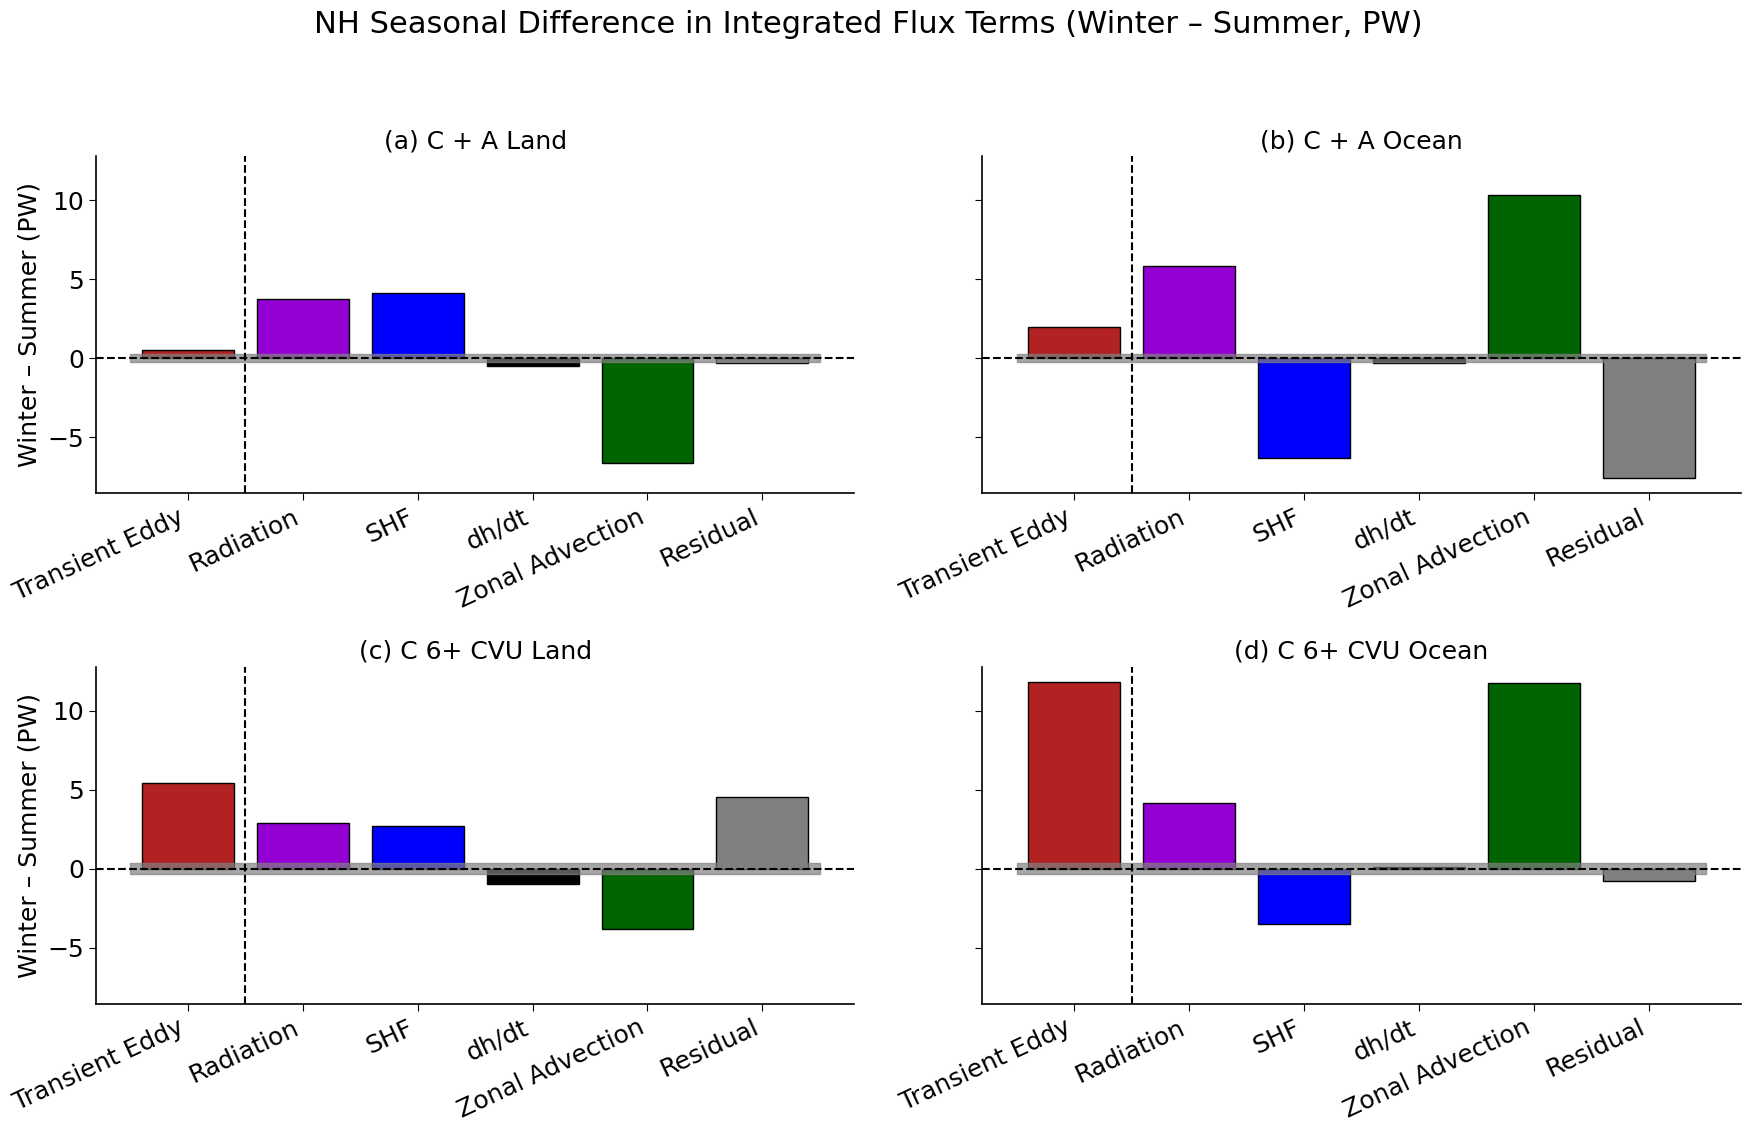

In [13]:
def compute_DI_NH_from_fields(*, fields, denom_mode, denom_values):
    out = {}
    denom_mean = float(np.mean(denom_values))
    for flux_name, arr in fields.items():
        arr_zon = np.mean(arr, axis=2)
        arr_int = interp_lat_2d(field_12x_nlat=arr_zon, x_d=x_d, y_d=y_d, x3_d=x3_d, y3_d=y3_d)
        maxN = mean_around_track(field_12x_nfine=arr_int, idx_12=stormtrack_NH)
        if denom_mode == "per_month":
            norm = A_EARTH * np.cos(np.deg2rad(stormtrack_lat_nh)) * 2 * np.pi * denom_values
        else:
            norm = A_EARTH * np.cos(np.deg2rad(stormtrack_lat_nh)) * 2 * np.pi * denom_mean
        series = maxN / norm
        out[flux_name] = series - np.mean(series)
    return out


def build_bar_values_pw(*, DI):
    te = DI["F_TE"] * 1e15
    swabs = DI["F_Swabs"] * 1e15
    olr = DI["F_Olr"] * 1e15
    shf = DI["F_Shf"] * 1e15
    dhdt = -DI["F_Dhdt"] * 1e15
    umz = -DI["F_UM_z"] * 1e15
    tot = DI["tot_energy"] * 1e15
    residual = te - (tot - (-dhdt)) + (-umz)
    values = [
        seasonal_diff(te), seasonal_diff(swabs + olr), seasonal_diff(shf),
        seasonal_diff(dhdt), seasonal_diff(umz), seasonal_diff(residual),
    ]
    return [v * PW_FACTOR for v in values]


def _make_field_dict(*, te, sw, olr, shf, dhdt, umz, tot, mask):
    return {
        "F_TE": te * mask, "F_Swabs": sw * mask, "F_Olr": olr * mask,
        "F_Shf": shf * mask, "F_Dhdt": dhdt * mask, "F_UM_z": umz * mask,
        "tot_energy": tot * mask,
    }


D_I_ca_oce = compute_DI_NH_from_fields(
    fields=_make_field_dict(te=te_ca0, sw=sw_ca0, olr=olr_ca0, shf=shf_ca0,
                           dhdt=dhdt_ca0, umz=umz_ca0, tot=tot_ca0, mask=ocean_mask_expanded),
    denom_mode="per_month", denom_values=area_oce_CA_cut1,
)
D_I_ca_lan = compute_DI_NH_from_fields(
    fields=_make_field_dict(te=te_ca0, sw=sw_ca0, olr=olr_ca0, shf=shf_ca0,
                           dhdt=dhdt_ca0, umz=umz_ca0, tot=tot_ca0, mask=land_mask_expanded),
    denom_mode="per_month", denom_values=area_lan_CA_cut1,
)

ones_mask = np.ones_like(ocean_mask_expanded)
D_I_cycl5_total = compute_DI_NH_from_fields(
    fields=_make_field_dict(te=te_c5, sw=sw_c5, olr=olr_c5, shf=shf_c5,
                           dhdt=dhdt_c5, umz=umz_c5, tot=tot_c5, mask=ones_mask),
    denom_mode="mean", denom_values=max_area_NH_cut6,
)
D_I_cycl5_land = compute_DI_NH_from_fields(
    fields=_make_field_dict(te=te_c5, sw=sw_c5, olr=olr_c5, shf=shf_c5,
                           dhdt=dhdt_c5, umz=umz_c5, tot=tot_c5, mask=land_mask_expanded),
    denom_mode="mean", denom_values=max_area_NH_cut6_land,
)
D_I_cycl5_oce = compute_DI_NH_from_fields(
    fields=_make_field_dict(te=te_c5, sw=sw_c5, olr=olr_c5, shf=shf_c5,
                           dhdt=dhdt_c5, umz=umz_c5, tot=tot_c5, mask=ocean_mask_expanded),
    denom_mode="mean", denom_values=max_area_NH_cut6_oce,
)

confidence_eulerian_NH = 0.3694333379314638 / 2 / (
    A_EARTH * np.cos(np.deg2rad(np.mean(stormtrack_lat_nh))) * 2 * np.pi
)

results_land_ocean = {
    "C + A Land": build_bar_values_pw(DI=D_I_ca_lan),
    "C + A Ocean": build_bar_values_pw(DI=D_I_ca_oce),
    "C 6+ CVU Land": build_bar_values_pw(DI=D_I_cycl5_land),
    "C 6+ CVU Ocean": build_bar_values_pw(DI=D_I_cycl5_oce),
}
conf_dict_pw = {
    "C + A Land": confidence_eulerian_NH * 1e15 * PW_FACTOR,
    "C + A Ocean": confidence_eulerian_NH * 1e15 * PW_FACTOR,
    "C 6+ CVU Land": confidence_6cvu_NH * 1e15 * PW_FACTOR,
    "C 6+ CVU Ocean": confidence_6cvu_NH * 1e15 * PW_FACTOR,
}

bar_labels = ["Transient Eddy", "Radiation", "SHF", "dh/dt", "Zonal Advection", "Residual"]
x_bar = np.arange(len(bar_labels))

fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
categories = ["C + A Land", "C + A Ocean", "C 6+ CVU Land", "C 6+ CVU Ocean"]

for i, region in enumerate(categories):
    ax = axs[i // 2, i % 2]
    ax.bar(x_bar, results_land_ocean[region], color=bar_colors, edgecolor="black")
    ax.axhline(0, color="black", linestyle="--")
    ax.axvline(0.5, color="black", linestyle="--", linewidth=1.5)
    ax.set_xticks(x_bar)
    ax.set_xticklabels(bar_labels, rotation=25, ha="right", fontsize=18)
    letter = string.ascii_lowercase[i]
    ax.set_title(f"({letter}) {region}", fontsize=18)
    if i % 2 == 0:
        ax.set_ylabel("Winter \u2013 Summer (PW)", fontsize=18)
    ax.fill_between([-0.5, len(x_bar) - 0.5],
                    conf_dict_pw[region], -conf_dict_pw[region],
                    color="gray", alpha=0.7)
    ax.tick_params(axis="y", labelsize=18)

fig.suptitle("NH Seasonal Difference in Integrated Flux Terms (Winter \u2013 Summer, PW)", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("CA_land_ocean_plus_6CVU_land_ocean_pw_FIXED.png", dpi=300, bbox_inches="tight")
plt.show()

## Figure 6 — 2-D global maps (weak and strong cyclone TE)

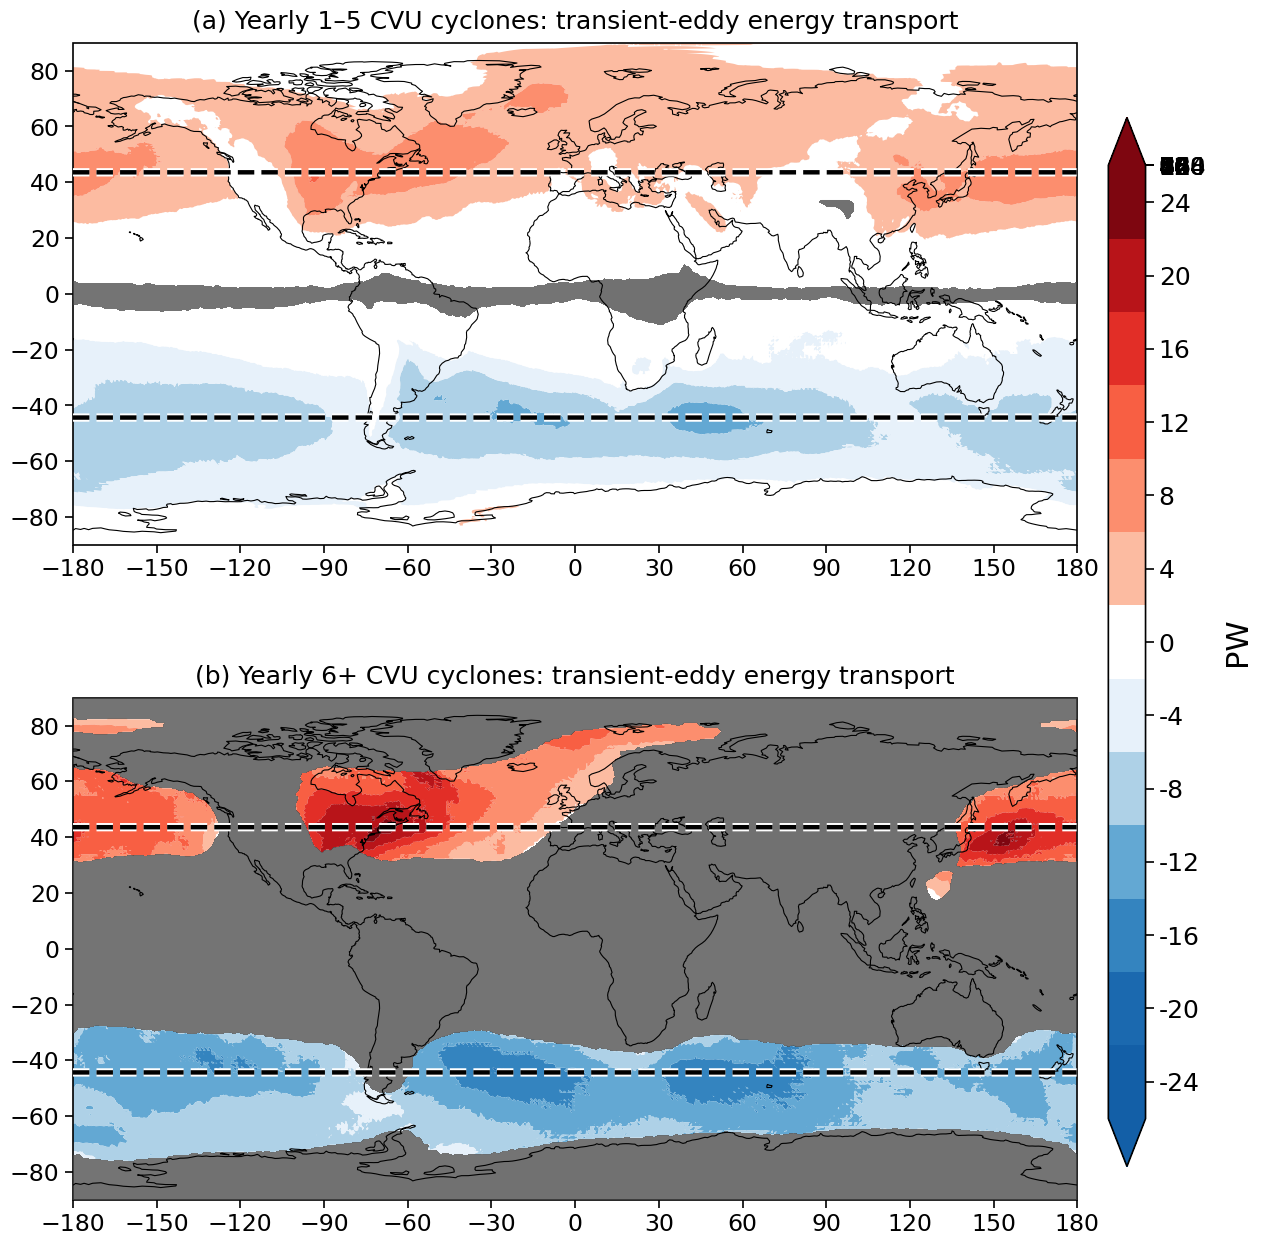

In [14]:
import matplotlib.transforms as _mt
_orig_union = _mt.Bbox.union
def _safe_union(bboxes):
    if not len(bboxes):
        return _mt.Bbox.unit()
    return _orig_union(bboxes)
_mt.Bbox.union = staticmethod(_safe_union)

mpl.rcParams.update({
    "font.size": 16,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.2,
    "xtick.major.size": 6, "ytick.major.size": 6,
    "xtick.major.width": 1.2, "ytick.major.width": 1.2,
})

def normalize_lon(lon_1d, *arrays_latlon):
    lon = np.asarray(lon_1d).copy()
    if lon.min() >= -180 and lon.max() <= 180 and np.all(np.diff(lon) > 0):
        return lon, arrays_latlon
    lon_wrapped = ((lon + 180) % 360) - 180
    order = np.argsort(lon_wrapped)
    lon_sorted = lon_wrapped[order]
    reindexed = [np.asarray(arr)[:, order] for arr in arrays_latlon]
    return lon_sorted, tuple(reindexed)

with netCDF4.Dataset(str(NC_FLUX), "r") as ds:
    F_TE_cycl_all_3d = ds["F_TE_final_cycl"][0, :, :, :]
    F_TE_cycl_strong_3d = ds["F_TE_final_cycl"][5, :, :, :]

cycl_int_data = load_nc_var(path=NC_CYC_INT, variable_name="cycl_int_final")

F_TE_cycl_weak_3d = F_TE_cycl_all_3d - F_TE_cycl_strong_3d
contour_weak = np.mean(cycl_int_data[0] - cycl_int_data[5], axis=0)
contour_strong = np.mean(cycl_int_data[5], axis=0)

data_weak = np.mean(F_TE_cycl_weak_3d, axis=0)
data_strong = np.mean(F_TE_cycl_strong_3d, axis=0)

wm_to_pw = (2 * np.pi * A_EARTH) * 1e-15
weights_2d = A_EARTH * np.cos(np.deg2rad(latitude))[:, None] * 2 * np.pi * 1e-15

field_weak_pw = (data_weak / weights_2d / contour_weak) * wm_to_pw
field_strong_pw = (data_strong / weights_2d / contour_strong) * wm_to_pw

frac_weak = contour_weak
frac_strong = contour_strong

lon_map, (field_weak_pw, frac_weak, field_strong_pw, frac_strong) = normalize_lon(
    longitude, field_weak_pw, frac_weak, field_strong_pw, frac_strong,
)

step_pw = 1e8 * wm_to_pw
edges_neg = np.arange(-6.5e8 * wm_to_pw, -0.5e8 * wm_to_pw + 1e-12, step_pw)
edges_pos = np.arange(0.5e8 * wm_to_pw, 6.5e8 * wm_to_pw + 1e-12, step_pw)
levels_map = np.concatenate([edges_neg, edges_pos])

neg_bins = len(edges_neg) - 1
pos_bins = len(edges_pos) - 1
gamma = 1.8
t_neg = 0.18 + (0.92 - 0.18) * (np.linspace(0, 1, neg_bins) ** gamma)
neg_colors = plt.get_cmap("Blues_r")(t_neg)
t_pos = np.linspace(0.25, 0.95, pos_bins)
pos_colors = plt.get_cmap("Reds")(t_pos)
colors = np.vstack([neg_colors, np.array([[1, 1, 1, 1]]), pos_colors])
CM = matplotlib.colors.ListedColormap(colors)
NORM = matplotlib.colors.BoundaryNorm(levels_map, CM.N, clip=False)

fig, axs = plt.subplots(2, 1, figsize=(12.4, 13.8),
                        subplot_kw={"projection": cartopy.crs.PlateCarree()})
fig.subplots_adjust(left=0.07, right=0.88, top=0.95, bottom=0.08, hspace=0.20)

for ax_idx, (field, frac, title, pos_nh, pos_sh) in enumerate([
    (field_weak_pw, frac_weak, "(a) Yearly 1\u20135 CVU cyclones: transient-eddy energy transport",
     float(np.mean(max_TE_position)), float(np.mean(max_TE_SH_position))),
    (field_strong_pw, frac_strong, "(b) Yearly 6+ CVU cyclones: transient-eddy energy transport",
     float(np.mean(max_TE_position)), float(np.mean(max_TE_SH_position))),
]):
    ax = axs[ax_idx]
    ax.set_extent([-180, 180, -90, 90], crs=cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND.with_scale("110m"), facecolor="#f6f6f6", edgecolor="none")
    ax.add_feature(cartopy.feature.COASTLINE.with_scale("110m"), linewidth=0.8, zorder=10)
    mask = frac < 0.05
    cs = ax.contourf(lon_map, latitude, np.where(mask, np.nan, field),
                     levels=levels_map, cmap=CM, norm=NORM,
                     transform=cartopy.crs.PlateCarree(), extend="both", antialiased=True)
    ax.contourf(lon_map, latitude, mask.astype(float), levels=[0.5, 1.0],
                colors=["#454545"], alpha=0.75,
                transform=cartopy.crs.PlateCarree(), zorder=5)
    halo = [matplotlib.patheffects.Stroke(linewidth=6, foreground="white"),
            matplotlib.patheffects.Normal()]
    ax.plot(lon_map, np.full_like(lon_map, pos_nh), ls="--", lw=3.2, color="black",
            path_effects=halo, transform=cartopy.crs.PlateCarree(), zorder=15)
    ax.plot(lon_map, np.full_like(lon_map, pos_sh), ls="--", lw=3.2, color="black",
            path_effects=halo, transform=cartopy.crs.PlateCarree(), zorder=15)
    ax.set_title(title, fontsize=18, pad=10)
    ax.set_xticks(np.arange(-180, 181, 30), crs=cartopy.crs.PlateCarree())
    ax.set_yticks(np.arange(-80, 81, 20), crs=cartopy.crs.PlateCarree())
    ax.tick_params(labelsize=17)

cax = fig.add_axes([0.905, 0.12, 0.03, 0.76])
cbar = fig.colorbar(cs, cax=cax)

tick_step = 4
tick_min = int(np.ceil(min(levels_map.min(), np.nanmin(field_weak_pw), np.nanmin(field_strong_pw)) / tick_step) * tick_step)
tick_max = int(np.floor(max(levels_map.max(), np.nanmax(field_weak_pw), np.nanmax(field_strong_pw)) / tick_step) * tick_step)
ticks = sorted(set(list(np.arange(tick_min, tick_max + tick_step, tick_step)) + [0]))
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(int(t)) for t in ticks])

cbar.ax.minorticks_off()
cbar.ax.tick_params(which="major", labelsize=18, length=6, width=1.2)
cbar.set_label("PW", fontsize=22, labelpad=12)

plt.savefig("2d_maps_PW.png", dpi=600, bbox_inches="tight")
plt.show()

## Figure 7 — Cyclone-centred composites (SH)

/tmp/jobs/47596769/ipykernel_10579/349251771.py:67: RuntimeWarning: Mean of empty slice
  return np.nanmean(fld, axis=1)
/home/gmsarro/.conda/envs/notebook_env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4786: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


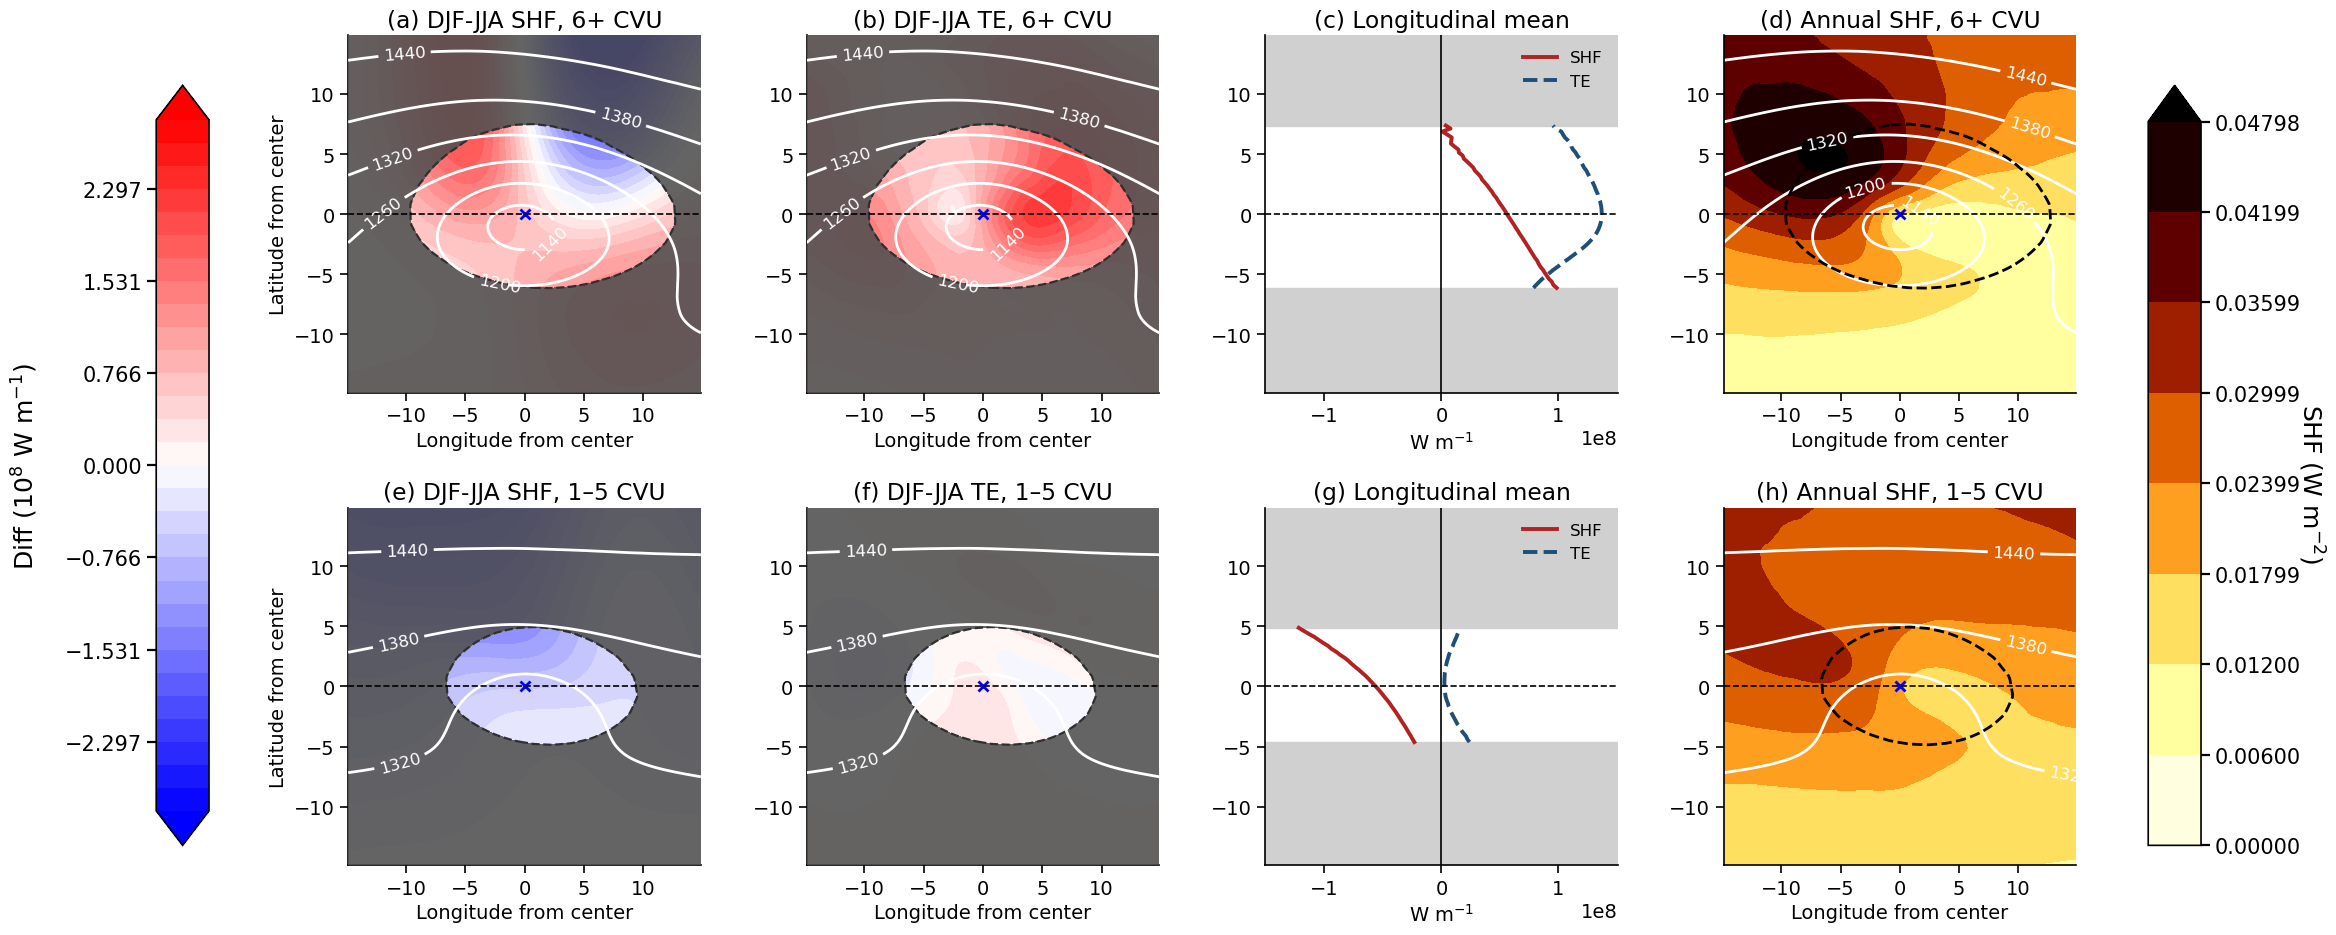

In [15]:
INTENSE_NC = str(BASE / "cyclone_centered" / "Intense_Composites_SH_only_noleap.nc")
REGULAR_NC = str(BASE / "cyclone_centered" / "Composites_SH_only_noleap.nc")
INTENSE_WM_SH = str(BASE / "cyclone_centered" / "Intense_Composites_W_M_TRACK_SH_.nc")
ALL_WM_SH = str(BASE / "cyclone_centered" / "Composites_W_M_TRACK_SH_.nc")

mpl.rcParams.update({"font.size": 14, "axes.spines.top": False, "axes.spines.right": False})


def sym_levels(*arrays, n=31, pct=99):
    a = np.nanmax([np.nanpercentile(np.abs(x), pct) for x in arrays])
    a = float(a) if np.isfinite(a) and a > 0 else 1.0
    return np.linspace(-a, a, n), -a, a


def pos_levels(*arrays, n=9, pct=99):
    a = np.nanmax([np.nanpercentile(x, pct) for x in arrays])
    a = float(a) if np.isfinite(a) and a > 0 else 1.0
    return np.linspace(0, a, n), 0, a


def monthly_scaler(cnt12):
    cnt12 = np.asarray(cnt12, float)
    tot = np.nansum(cnt12)
    return (12.0 * cnt12 / tot) if tot > 0 else np.ones(12, float)


def season_weighted(field_m, weights, months_1based):
    idx = [m - 1 for m in months_1based]
    scaled = [weights[i] * field_m[i] for i in idx]
    return (scaled[0] + scaled[1] + scaled[2]) / 3.0


def build_weight_cube(*, lat_row_base, maxpos12):
    lat_row_base = np.asarray(lat_row_base, float)
    maxpos12 = np.asarray(maxpos12, float).reshape(12)
    weight = np.empty((12, lat_row_base.shape[0], 120), float)
    for i in range(12):
        row_deg = lat_row_base + maxpos12[i]
        lat2d = np.tile(row_deg[:, None], (1, 120))
        weight[i] = A_EARTH * np.cos(np.deg2rad(lat2d)) * 2 * np.pi * 1e-15
    return weight


def nice_met_levels(zmin, zmax, interval=60.0):
    lo = interval * np.floor(zmin / interval)
    hi = interval * np.ceil(zmax / interval)
    nlev = max(4, int((hi - lo) / interval) + 1)
    return np.linspace(lo, hi, nlev)


def ensure_lat_alignment(field2d, lat_src, lat_target):
    lat_src = np.asarray(lat_src)
    lat_target = np.asarray(lat_target)
    if lat_src.shape == lat_target.shape and np.allclose(lat_src, lat_target, atol=1e-9, rtol=0):
        return field2d
    if lat_src.shape == lat_target.shape and np.allclose(lat_src[::-1], lat_target, atol=1e-9, rtol=0):
        return field2d[::-1, :]
    asc_src = np.all(np.diff(lat_src) > 0)
    asc_targ = np.all(np.diff(lat_target) > 0)
    if asc_src != asc_targ:
        return field2d[::-1, :]
    return field2d


def masked_longitudinal_mean(field2d, mask2d):
    fld = np.where(mask2d, field2d, np.nan)
    return np.nanmean(fld, axis=1)


def lat_band_from_mask(mask2d, lat):
    rows = np.where(mask2d.any(axis=1))[0]
    if rows.size == 0:
        return None
    ylo, yhi = float(lat[rows[0]]), float(lat[rows[-1]])
    if ylo > yhi:
        ylo, yhi = yhi, ylo
    return ylo, yhi


def gray_outside_exact(*, ax, VO_ref, lon, lat, alpha=0.88):
    vmax = float(np.nanmax(VO_ref)) + 1.0
    ax.contourf(lon, lat, VO_ref, levels=[-1.0, vmax], colors=["#505050"], alpha=alpha, zorder=15)
    ax.contour(lon, lat, VO_ref, levels=[-1.0], colors="#2f2f2f", linewidths=1.6, zorder=20)


with netCDF4.Dataset(INTENSE_WM_SH, "r") as f_intense:
    lat_wm_sh = f_intense["lat"][:]
    composite_VO_intense = f_intense["composite_VO"][:, :, :]
    composite_Z_intense = f_intense["composite_Z"][:, :, :]
    composite_SLHF_intense = f_intense["composite_SLHF"][:, :, :]
    I_number = f_intense["number"][:].astype(float)

with netCDF4.Dataset(ALL_WM_SH, "r") as f_all:
    composite_VO_all = f_all["composite_VO"][:, :, :]
    composite_Z_all = f_all["composite_Z"][:, :, :]
    composite_SLHF_all = f_all["composite_SLHF"][:, :, :]
    all_number = f_all["number"][:].astype(float)

ds6 = xarray.open_dataset(INTENSE_NC)
ds15 = xarray.open_dataset(REGULAR_NC)

TE6 = ds6["composite_TE"].values
SHF6 = ds6["composite_Shf"].values
cnt6 = ds6["count"].values.astype(float)
x6 = ds6["x"].values
y6 = ds6["y"].values

TE15 = ds15["composite_TE"].values
SHF15 = ds15["composite_Shf"].values
cnt15 = ds15["count"].values.astype(float)
x15 = ds15["x"].values
y15 = ds15["y"].values

wgt6 = build_weight_cube(lat_row_base=lat_wm_sh, maxpos12=max_TE_SH_position)
wgt15 = build_weight_cube(lat_row_base=lat_wm_sh, maxpos12=max_TE_SH_position)

TE6_Wm = TE6 / wgt6
SHF6_Wm = SHF6 / wgt6
TE15_Wm = TE15 / wgt15
SHF15_Wm = SHF15 / wgt15

w6 = monthly_scaler(cnt6)
w15 = monthly_scaler(cnt15)

A_shf = season_weighted(SHF6_Wm, w6, [12, 1, 2]) - season_weighted(SHF6_Wm, w6, [6, 7, 8])
B_te = season_weighted(TE6_Wm, w6, [12, 1, 2]) - season_weighted(TE6_Wm, w6, [6, 7, 8])
E_shf = season_weighted(SHF15_Wm, w15, [12, 1, 2]) - season_weighted(SHF15_Wm, w15, [6, 7, 8])
F_te = season_weighted(TE15_Wm, w15, [12, 1, 2]) - season_weighted(TE15_Wm, w15, [6, 7, 8])

SCALE = 1e8
A_shf_map = A_shf / SCALE
B_te_map = B_te / SCALE
E_shf_map = E_shf / SCALE
F_te_map = F_te / SCALE

I_number_3d = I_number[:, None, None]
all_number_3d = all_number[:, None, None]
composite_VO_weak = composite_VO_all * (all_number_3d + I_number_3d) / all_number_3d - composite_VO_intense * I_number_3d / all_number_3d
composite_Z_weak = composite_Z_all * (all_number_3d + I_number_3d) / all_number_3d - composite_Z_intense * I_number_3d / all_number_3d
composite_SLHF_weak = composite_SLHF_all * (all_number_3d + I_number_3d) / all_number_3d - composite_SLHF_intense * I_number_3d / all_number_3d

VO_mean_6 = 0.5 * (season_weighted(composite_VO_intense, w6, [12, 1, 2])
                    + season_weighted(composite_VO_intense, w6, [6, 7, 8]))
VO_mean_15 = 0.5 * (season_weighted(composite_VO_weak, w15, [12, 1, 2])
                     + season_weighted(composite_VO_weak, w15, [6, 7, 8]))

Z_DJF_6 = (composite_Z_intense[11] + composite_Z_intense[0] + composite_Z_intense[1]) / 3
Z_JJA_6 = np.mean(composite_Z_intense[5:8], axis=0)
Z_avg_6 = 0.5 * (Z_DJF_6 + Z_JJA_6)

Z_DJF_15 = (composite_Z_weak[11] + composite_Z_weak[0] + composite_Z_weak[1]) / 3
Z_JJA_15 = np.mean(composite_Z_weak[5:8], axis=0)
Z_avg_15 = 0.5 * (Z_DJF_15 + Z_JJA_15)

D_slhf_sum6 = np.nansum(cnt6)
D_slhf = np.nansum(composite_SLHF_intense * cnt6[:, None, None], axis=0) / D_slhf_sum6 if D_slhf_sum6 > 0 else np.nan * composite_SLHF_intense[0]
# composite_SLHF is already in W/m² (ERA5 slhf+sshf, recomposited from actual data)

G_slhf_sum15 = np.nansum(cnt15)
G_slhf = np.nansum(composite_SLHF_weak * cnt15[:, None, None], axis=0) / G_slhf_sum15 if G_slhf_sum15 > 0 else np.nan * composite_SLHF_weak[0]
# composite_SLHF is already in W/m² (ERA5 slhf+sshf, recomposited from actual data)

VO_mean_6_te = ensure_lat_alignment(VO_mean_6, lat_wm_sh, y6)
Z_avg_6_te = ensure_lat_alignment(Z_avg_6, lat_wm_sh, y6)
VO_mean_15_te = ensure_lat_alignment(VO_mean_15, lat_wm_sh, y15)
Z_avg_15_te = ensure_lat_alignment(Z_avg_15, lat_wm_sh, y15)

mask_6 = (VO_mean_6_te < -1.0)
mask_15 = (VO_mean_15_te < -1.0)

C_shf = masked_longitudinal_mean(A_shf, mask_6)
C_te = masked_longitudinal_mean(B_te, mask_6)
H_shf = masked_longitudinal_mean(E_shf, mask_15)
H_te = masked_longitudinal_mean(F_te, mask_15)

band6 = lat_band_from_mask(mask_6, y6)
band15 = lat_band_from_mask(mask_15, y15)

lev_diff_map, vmin_diff, vmax_diff = sym_levels(A_shf_map, E_shf_map, B_te_map, F_te_map, n=31, pct=99)
lev_slhf, v0_s, v1_s = pos_levels(D_slhf, G_slhf, n=9, pct=99)

fig, axs = plt.subplots(2, 4, figsize=(24, 10))
plt.subplots_adjust(wspace=0.30, hspace=0.32, left=0.18, right=0.90, top=0.93, bottom=0.10)

X6, Y6 = np.meshgrid(x6, y6)
X15, Y15 = np.meshgrid(x15, y15)

zmin = float(np.nanmin([np.nanmin(Z_avg_6), np.nanmin(Z_avg_15)]))
zmax = float(np.nanmax([np.nanmax(Z_avg_6), np.nanmax(Z_avg_15)]))
levels_Z = nice_met_levels(zmin, zmax, interval=60.0)
ctr_lw = 2.0
lab_fs = 12


def storm_lat_line(ax):
    ax.axhline(0, color="k", lw=1.2, ls="--", zorder=40)


ax = axs[0, 0]
im_a = ax.contourf(X6, Y6, A_shf_map, levels=lev_diff_map, cmap="bwr",
                   vmin=vmin_diff, vmax=vmax_diff, extend="both", zorder=1)
gray_outside_exact(ax=ax, VO_ref=VO_mean_6_te, lon=x6, lat=y6, alpha=0.88)
csZ = ax.contour(x6, y6, Z_avg_6_te, levels=levels_Z, colors="white", linewidths=ctr_lw, zorder=25)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.plot(0, 0, "bx", ms=7, mew=2, zorder=35)
storm_lat_line(ax)
ax.set_title("(a) DJF-JJA SHF, 6+ CVU")
ax.set_xlabel("Longitude from center")
ax.set_ylabel("Latitude from center")

ax = axs[0, 1]
ax.contourf(X6, Y6, B_te_map, levels=lev_diff_map, cmap="bwr",
            vmin=vmin_diff, vmax=vmax_diff, extend="both", zorder=1)
gray_outside_exact(ax=ax, VO_ref=VO_mean_6_te, lon=x6, lat=y6, alpha=0.88)
csZ = ax.contour(x6, y6, Z_avg_6_te, levels=levels_Z, colors="white", linewidths=ctr_lw, zorder=25)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.plot(0, 0, "bx", ms=7, mew=2, zorder=35)
storm_lat_line(ax)
ax.set_title("(b) DJF-JJA TE, 6+ CVU")
ax.set_xlabel("Longitude from center")

ax_c = axs[0, 2]
ax_c.set_ylim(y6.min(), y6.max())
ax_c.plot(C_shf, y6, color="#b22222", lw=2.8, label="SHF")
ax_c.plot(C_te, y6, color="#1f4e79", lw=2.8, ls="--", label="TE")
storm_lat_line(ax_c)
ax_c.axvline(0, color="k", lw=1.2)
if band6 is not None:
    ylo, yhi = band6
    ax_c.axhspan(y6.min(), ylo, color="#d0d0d0", zorder=0)
    ax_c.axhspan(yhi, y6.max(), color="#d0d0d0", zorder=0)
ax_c.set_title("(c) Longitudinal mean")
ax_c.set_xlabel(r"W m$^{-1}$")
ax_c.legend(frameon=False, fontsize=12)

lon_wm = x6
ax = axs[0, 3]
im_d = ax.contourf(lon_wm, lat_wm_sh, D_slhf, levels=lev_slhf, cmap="afmhot_r",
                   vmin=v0_s, vmax=v1_s, extend="max")
Z_avg_6_wm = ensure_lat_alignment(Z_avg_6_te, y6, lat_wm_sh)
VO_mean_6_wm = ensure_lat_alignment(VO_mean_6_te, y6, lat_wm_sh)
csZ = ax.contour(lon_wm, lat_wm_sh, Z_avg_6_wm, levels=levels_Z, colors="white", linewidths=ctr_lw)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.contour(lon_wm, lat_wm_sh, VO_mean_6_wm, levels=[-1.0], colors="k", linewidths=ctr_lw)
ax.plot(0, 0, "bx", ms=7, mew=2)
storm_lat_line(ax)
ax.set_title("(d) Annual SHF, 6+ CVU")
ax.set_xlabel("Longitude from center")

ax = axs[1, 0]
ax.contourf(X15, Y15, E_shf_map, levels=lev_diff_map, cmap="bwr",
            vmin=vmin_diff, vmax=vmax_diff, extend="both", zorder=1)
gray_outside_exact(ax=ax, VO_ref=VO_mean_15_te, lon=x15, lat=y15, alpha=0.88)
csZ = ax.contour(x15, y15, Z_avg_15_te, levels=levels_Z, colors="white", linewidths=ctr_lw, zorder=25)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.plot(0, 0, "bx", ms=7, mew=2, zorder=35)
storm_lat_line(ax)
ax.set_title("(e) DJF-JJA SHF, 1\u20135 CVU")
ax.set_xlabel("Longitude from center")
ax.set_ylabel("Latitude from center")

ax = axs[1, 1]
ax.contourf(X15, Y15, F_te_map, levels=lev_diff_map, cmap="bwr",
            vmin=vmin_diff, vmax=vmax_diff, extend="both", zorder=1)
gray_outside_exact(ax=ax, VO_ref=VO_mean_15_te, lon=x15, lat=y15, alpha=0.88)
csZ = ax.contour(x15, y15, Z_avg_15_te, levels=levels_Z, colors="white", linewidths=ctr_lw, zorder=25)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.plot(0, 0, "bx", ms=7, mew=2, zorder=35)
storm_lat_line(ax)
ax.set_title("(f) DJF-JJA TE, 1\u20135 CVU")
ax.set_xlabel("Longitude from center")

ax_g = axs[1, 2]
ax_g.set_ylim(y15.min(), y15.max())
ax_g.plot(H_shf, y15, color="#b22222", lw=2.8, label="SHF")
ax_g.plot(H_te, y15, color="#1f4e79", lw=2.8, ls="--", label="TE")
storm_lat_line(ax_g)
ax_g.axvline(0, color="k", lw=1.2)
if band15 is not None:
    ylo, yhi = band15
    ax_g.axhspan(y15.min(), ylo, color="#d0d0d0", zorder=0)
    ax_g.axhspan(yhi, y15.max(), color="#d0d0d0", zorder=0)
ax_g.set_title("(g) Longitudinal mean")
ax_g.set_xlabel(r"W m$^{-1}$")
ax_g.legend(frameon=False, fontsize=12)

ax = axs[1, 3]
im_h = ax.contourf(lon_wm, lat_wm_sh, G_slhf, levels=lev_slhf, cmap="afmhot_r",
                   vmin=v0_s, vmax=v1_s, extend="max")
Z_avg_15_wm = ensure_lat_alignment(Z_avg_15_te, y15, lat_wm_sh)
VO_mean_15_wm = ensure_lat_alignment(VO_mean_15_te, y15, lat_wm_sh)
csZ = ax.contour(lon_wm, lat_wm_sh, Z_avg_15_wm, levels=levels_Z, colors="white", linewidths=ctr_lw)
ax.clabel(csZ, fmt="%1.0f", fontsize=lab_fs, colors="white", inline=0.01)
ax.contour(lon_wm, lat_wm_sh, VO_mean_15_wm, levels=[-1.0], colors="k", linewidths=ctr_lw)
ax.plot(0, 0, "bx", ms=7, mew=2)
storm_lat_line(ax)
ax.set_title("(h) Annual SHF, 1\u20135 CVU")
ax.set_xlabel("Longitude from center")

xmax_lm = np.nanmax(np.abs([C_shf, C_te, H_shf, H_te])) * 1.1
for ax_lm in (axs[0, 2], axs[1, 2]):
    ax_lm.set_xlim(-xmax_lm, xmax_lm)

cax_diff = fig.add_axes([0.1, 0.12, 0.022, 0.76])
cb_diff = fig.colorbar(im_a, cax=cax_diff)
cb_diff.set_label(r"Diff ($10^8$ W m$^{-1}$)", rotation=90, labelpad=18, fontsize=18)
cb_diff.ax.yaxis.set_ticks_position("left")
cb_diff.ax.yaxis.set_label_position("left")
cb_diff.ax.tick_params(labelsize=15, length=6.5, width=1.6)

cax_s = fig.add_axes([0.93, 0.12, 0.022, 0.76])
cb_s = fig.colorbar(im_d, cax=cax_s)
cb_s.set_label(r"SHF (W m$^{-2}$)", rotation=270, labelpad=18, fontsize=18)
cb_s.ax.tick_params(labelsize=15, length=6.5, width=1.6)

plt.savefig("Composites.png", dpi=600, bbox_inches="tight")
plt.show()

ds6.close()
ds15.close()